<a href="https://colab.research.google.com/github/PiotrChylak/-Comparative-analysis-of-Buy-Hold-and-Momentum-12-1-strategies/blob/main/Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projekt R - Test ogólności strategii (Buy&Hold i Momentum 12-1)

## Funkcje 🐛

In [19]:
# Załadowanie potrzebnych bibliotek
if(!require(gridExtra)) install.packages("gridExtra")
if(!require(scales)) install.packages("scales")

library(tidyverse)
library(lubridate)
library(scales)
library(grid)
library(gridExtra)

### Tworzenie ramek danych i wizualizacja (ceny w czasie)

In [20]:
plot_date_price <- function(df, date_col, price_col, title) {
  data <- df %>%
    mutate(Date = as.Date(!!sym(date_col)),
           Value = as.numeric(!!sym(price_col))) %>%
    filter(!is.na(Date) & !is.na(Value)) %>%
    arrange(Date)

  ggplot(data, aes(x = Date, y = Value)) +
    geom_line(color = "steelblue", linewidth = 0.7) +

    geom_point(color = "steelblue", linewidth = 1) +
    scale_x_date(date_breaks = "6 months", date_labels = "%m-%Y") +
    labs(title = title, x = "Miesiąc-Rok", y = price_col) +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

### Buy & Hold

In [21]:
equity_buy_hold <- function(prices_df, date_col = "Date", price_col = "Price", start_value = 1.0) {
  df <- prices_df %>%
    mutate(Date = as.Date(!!sym(date_col)),
           Price = as.numeric(!!sym(price_col))) %>%
    arrange(Date) %>%
    mutate(
      Return = Price / lag(Price) - 1,
      Return = ifelse(is.na(Return), 0, Return),
      Wealth = start_value * cumprod(1 + Return)
    ) %>%
    select(Date, Wealth, Return)

  return(df)
}

### Momentum 12-1

In [22]:
equity_momentum_12_1 <- function(prices_df, date_col = "Date", price_col = "Price", start_value = 1.0) {
  df <- prices_df %>%
    mutate(Date = as.Date(!!sym(date_col)),
           Price = as.numeric(!!sym(price_col))) %>%
    arrange(Date) %>%
    mutate(
      Asset_Return = Price / lag(Price) - 1,
      Momentum_Signal = lag(Price, 1) / lag(Price, 12) - 1,
      Position = ifelse(!is.na(Momentum_Signal) & Momentum_Signal > 0, 1, 0),
      Strat_Return = ifelse(is.na(Position * Asset_Return), 0, Position * Asset_Return),
      Wealth = start_value * cumprod(1 + Strat_Return)
    ) %>%
    select(Date, Wealth, Return = Strat_Return)

  return(df)
}

### Metryki

In [23]:
calculate_performance_metrics <- function(equity_df, rf_annual = 0.0, periods_per_year = 12) {
  # CAGR
  w0 <- equity_df$Wealth[1]
  w1 <- tail(equity_df$Wealth, 1)
  days <- as.numeric(difftime(max(equity_df$Date), min(equity_df$Date), units = "days"))
  years <- days / 365.25
  cagr <- (w1 / w0)^(1 / years) - 1

  # Volatility (Zmienność roczna)
  vol <- sd(equity_df$Return, na.rm = TRUE) * sqrt(periods_per_year)

  # Sharpe Ratio
  rf_period <- (1 + rf_annual)^(1 / periods_per_year) - 1
  excess_returns <- equity_df$Return - rf_period
  sharpe <- (mean(excess_returns, na.rm = TRUE) / sd(excess_returns, na.rm = TRUE)) * sqrt(periods_per_year)

  return(data.frame(CAGR = cagr, Volatility = vol, Sharpe = sharpe))
}

### Maksymalne odsunięcie

In [24]:
max_drawdown <- function(equity_df) {
  wealth <- equity_df$Wealth
  peak <- cummax(wealth)
  drawdown <- (wealth / peak) - 1
  return(min(drawdown))
}

### Różnica średnich (Test T-studenta)

In [25]:
ttest_paired <- function(ret_a_df, ret_b_df) {
  merged <- inner_join(ret_a_df, ret_b_df, by = "Date", suffix = c("_A", "_B"))

  test_res <- t.test(merged$Return_A, merged$Return_B, paired = TRUE)

  return(list(
    t_stat = test_res$statistic,
    p_value = test_res$p.value,
    mean_A = mean(merged$Return_A),
    mean_B = mean(merged$Return_B)
  ))
}

### Tworzenie głównego raportu

In [26]:
# --- GŁÓWNA FUNKCJA ANALITYCZNA ---
run_analysis <- function(prices_df, asset_name) {

  # 1. Przygotowanie danych i strategii
  bh_equity <- equity_buy_hold(prices_df)
  mom_equity <- equity_momentum_12_1(prices_df)

  # Stałe do formatowania
  width <- 75
  sep_line <- paste0(strrep("=", width), "\n")

  center_text <- function(text, width) {
    pad <- max(0, floor((width - nchar(text)) / 2))
    return(paste0(strrep(" ", pad), text, "\n"))
  }

  date_range <- paste0("Zakres dat: ", min(bh_equity$Date), " do ", max(bh_equity$Date),
                       "\nLiczba miesięcznych obserwacji: ", nrow(bh_equity))

  # --- SEKCJA 1: DANE WEJŚCIOWE I WYKRES CENY ---
  p1 <- plot_date_price(prices_df, "Date", "Price",
                        paste(asset_name, "/ 1. DANE WEJŚCIOWE I WYKRES CENY")) +
        labs(subtitle = date_range) +
        theme(plot.title = element_text(hjust = 0.5, face = "bold", linewidth = 14),
              plot.subtitle = element_text(hjust = 0.5, linewidth = 11, color = "grey30"))
  print(p1)

  # --- SEKCJA 2: KRZYWE KAPITAŁU (EQUITY CURVES) ---
  p2 <- ggplot() +
    geom_line(data = bh_equity, aes(x = Date, y = Wealth, color = "Buy & Hold"), linewidth = 1) +
    geom_line(data = mom_equity, aes(x = Date, y = Wealth, color = "Momentum 12-1"), linewidth = 1) +
    scale_y_log10() +
    scale_x_date(date_breaks = "1 year", date_labels = "%Y") +
    labs(title = paste(asset_name, "/ 2. KRZYWE KAPITAŁU (EQUITY CURVES)"),
         subtitle = "Porównanie skumulowanych stóp zwrotu (Skala Logarytmiczna)",
         y = "Wealth", x = "Rok") +
    theme_minimal() +
    theme(legend.position = "bottom",
          plot.title = element_text(hjust = 0.5, face = "bold", linewidth = 14),
          plot.subtitle = element_text(hjust = 0.5, linewidth = 11, color = "grey30")) +
    scale_color_manual(values = c("Buy & Hold" = "#32CD32", "Momentum 12-1" = "#FFA500"))
  print(p2)

  # --- SEKCJA 3: METRYKI EFEKTYWNOŚCI ---
  m_bh <- calculate_performance_metrics(bh_equity)
  m_bh$Max_Drawdown <- max_drawdown(bh_equity)
  m_bh$Strategia <- "Buy & Hold"

  m_mom <- calculate_performance_metrics(mom_equity)
  m_mom$Max_Drawdown <- max_drawdown(mom_equity)
  m_mom$Strategia <- "Momentum 12-1"

  summary_table <- rbind(m_bh, m_mom) %>%
    mutate(CAGR = percent(CAGR, 0.01),
           Volatility = percent(Volatility, 0.01),
           Sharpe = round(Sharpe, 2),
           Max_Drawdown = percent(Max_Drawdown, 0.01)) %>%
    select(Strategia, CAGR, Volatility, Sharpe, `Max Drawdown` = Max_Drawdown)

  t1 <- textGrob(paste(asset_name, "/ 3. METRYKI EFEKTYWNOŚCI"),
                 gp = gpar(fontsize = 14, fontface = "bold"))
  t2 <- tableGrob(summary_table, rows = NULL)
  grid.arrange(t1, t2, ncol = 1, heights = unit(c(1, 3), "cm"))

  # --- SEKCJA 4: ROCZNE STOPY ZWROTU ---
  get_yearly <- function(eq, lab) {
    eq %>% mutate(Year = year(Date)) %>% group_by(Year) %>%
      summarise(Return = tail(Wealth, 1) / head(Wealth, 1) - 1) %>% rename(!!lab := Return)
  }

  yearly_merged <- inner_join(get_yearly(bh_equity, "Buy&Hold"),
                              get_yearly(mom_equity, "Momentum12-1"), by = "Year")

  p3 <- yearly_merged %>% pivot_longer(cols = -Year, names_to = "Strategia", values_to = "Return") %>%
    ggplot(aes(x = factor(Year), y = Return, fill = Strategia)) +
    geom_col(position = "dodge") +
    geom_hline(yintercept = 0, color = "black") +
    scale_y_continuous(labels = percent) +
    labs(title = paste(asset_name, "/ 4. ROCZNE STOPY ZWROTU"),
         x = "Rok", y = "Stopa zwrotu") +
    theme_minimal() +
    theme(legend.position = "bottom",
          plot.title = element_text(hjust = 0.5, face = "bold", linewidth = 14)) +
    scale_fill_manual(values = c("Buy&Hold" = "#32CD32", "Momentum12-1" = "#FFA500"))
  print(p3)

  # Zmieniono wyświetlanie tabeli na terminalowe
  cat("\nSzczegółowe wartości zwrotów rocznych:\n")
  yearly_formatted <- yearly_merged %>%
    mutate(across(-Year, ~ percent(., 0.01)))
  print(as.data.frame(yearly_formatted), row.names = FALSE)
  cat("\n")

  # --- SEKCJA 5: TEST STATYSTYCZNY ---
  t_res <- ttest_paired(bh_equity %>% select(Date, Return), mom_equity %>% select(Date, Return))

  ttest_df <- data.frame(
    n = length(bh_equity$Return) - 1,
    meanA = percent(t_res$mean_A, 0.0001),
    meanB = percent(t_res$mean_B, 0.0001),
    `diff(A-B)` = percent(t_res$mean_A - t_res$mean_B, 0.0001),
    t_stat = round(as.numeric(t_res$t_stat), 3),
    p_value = round(as.numeric(t_res$p_value), 4)
  )

  t3 <- textGrob(paste(asset_name, "/ 5. TEST T (SPAROWANY)"),
                 gp = gpar(fontsize = 14, fontface = "bold"))
  t4 <- tableGrob(ttest_df, rows = NULL)
  grid.arrange(t3, t4, ncol = 1, heights = unit(c(1, 2), "cm"))
}

## Przygotowanie Danych ⛏

### Kryptowaluty

In [27]:
path <- "https://raw.githubusercontent.com/PiotrChylak/-Comparative-analysis-of-Buy-Hold-and-Momentum-12-1-strategies/main/Data/"

process_crypto_data <- function(url_path, file_name) {
  full_url <- paste0(url_path, file_name)

  df <- tryCatch({
    read.csv(full_url)
  }, error = function(e) {
    stop(paste("Nie można pobrać pliku z adresu:", full_url, "\nBłąd:", e$message))
  })

  df_processed <- df %>%
    select(Date, Price = Close) %>%
    mutate(Date = as.Date(Date)) %>%
    mutate(YearMonth = floor_date(Date, "month")) %>%
    group_by(YearMonth) %>%
    filter(Date == max(Date)) %>%
    ungroup() %>%
    select(Date, Price) %>%
    arrange(Date)

  return(df_processed)
}

SOL_prices_m <- process_crypto_data(path, "coin_Solana.csv")
ETH_prices_m <- process_crypto_data(path, "coin_Ethereum.csv")
BTC_prices_m <- process_crypto_data(path, "coin_Bitcoin.csv")

### S&P500

In [28]:
library(tidyverse)
library(lubridate)

path <- "https://raw.githubusercontent.com/PiotrChylak/-Comparative-analysis-of-Buy-Hold-and-Momentum-12-1-strategies/main/Data/"

returns_raw <- read.csv(paste0(path, "returns.csv"))
prices_raw  <- read.csv(paste0(path, "prices.csv"))

# 1. Przetworzenie stóp zwrotu
sp500_processed <- returns_raw %>%
  mutate(Date = as.Date(Date)) %>%
  arrange(Date)

# 2. Obliczenie średniego zwrotu miesięcznego (Equal-Weight)
# Wykluczamy kolumnę Date z obliczeń średniej
numeric_cols <- sapply(sp500_processed, is.numeric)
sp500_monthly_ret <- rowMeans(sp500_processed[, numeric_cols], na.rm = TRUE)

# 3. Tworzenie "Wealth Index" (odpowiednik ceny)
# Zaczynamy od 1.0 i mnożymy przez (1 + r)
sp500_wealth_index <- cumprod(1 + sp500_monthly_ret)


SP500_prices_m <- data.frame(
  Date = sp500_processed$Date,
  Price = sp500_wealth_index
)

SP500_returns_m <- data.frame(
  Date = sp500_processed$Date,
  Return = sp500_monthly_ret
)

head(SP500_prices_m)
head(SP500_returns_m)

,Date,Price
,<date>,<dbl>
1,2017-01-01,1.030329
2,2017-02-01,1.069226
3,2017-03-01,1.073250
4,2017-04-01,1.088282
5,2017-05-01,1.105812
6,2017-06-01,1.117510


,Date,Return
,<date>,<dbl>
1,2017-01-01,0.03032920
2,2017-02-01,0.03775147
3,2017-03-01,0.00376352
4,2017-04-01,0.01400611
5,2017-05-01,0.01610845
6,2017-06-01,0.01057862


### Złoto

In [29]:
library(tidyverse)
library(lubridate)

path <- "https://raw.githubusercontent.com/PiotrChylak/-Comparative-analysis-of-Buy-Hold-and-Momentum-12-1-strategies/main/Data/"

gold_raw  <- read.csv(file.path(path, "monthly_csv.csv"))

# 3. NAPRAWA DATY: Doklejamy "-01" do każdego wpisu, aby R rozpoznał to jako datę
# Z formatu "1950-01" zrobi się "1950-01-01"
gold_raw$Date <- paste0(gold_raw$Date, "-01")

gold_filtered <- gold_raw %>%
  filter(Date >= as.Date("2002-01-01"))

head(gold_filtered)
tail(gold_filtered)

,Date,Price
,<chr>,<dbl>
1,2002-01-01,281.764
2,2002-02-01,295.683
3,2002-03-01,294.353
4,2002-04-01,302.862
5,2002-05-01,314.480
6,2002-06-01,321.536


,Date,Price
,<chr>,<dbl>
218,2020-02-01,1598.818
219,2020-03-01,1593.764
220,2020-04-01,1680.030
221,2020-05-01,1715.697
222,2020-06-01,1734.032
223,2020-07-01,1840.807


## Wyniki końcowe 📈

### Złoto

Warning message in geom_point(color = "steelblue", linewidth = 1):
“Ignoring unknown parameters: `linewidth`”
Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”
Warning message in element_text(hjust = 0.5, linewidth = 11, color = "grey30"):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 11”
Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”
Warning message in element_text(hjust = 0.5, linewidth = 11, color = "grey30"):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 11”


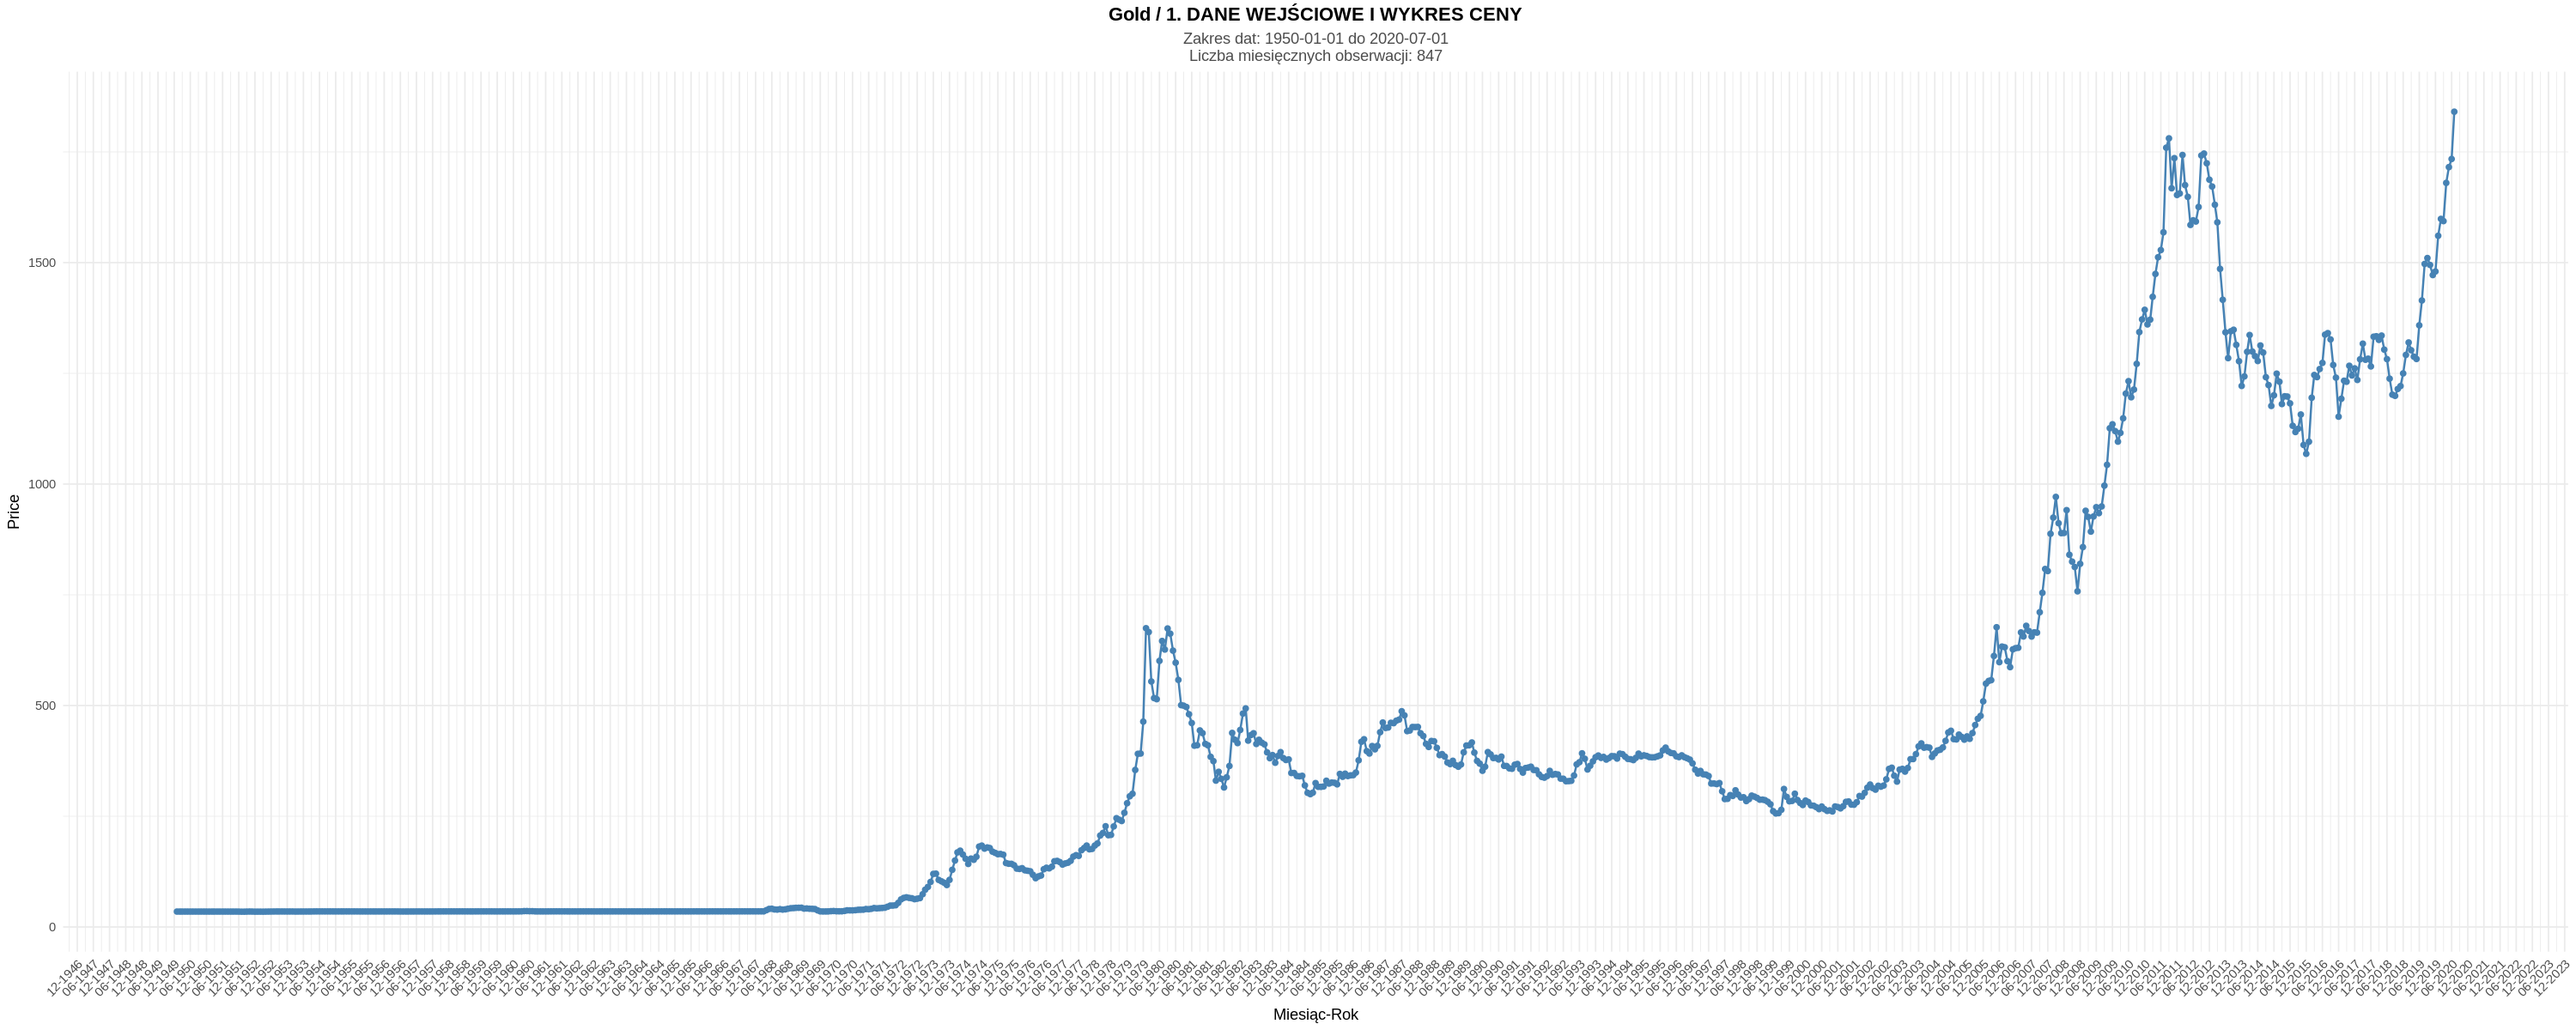

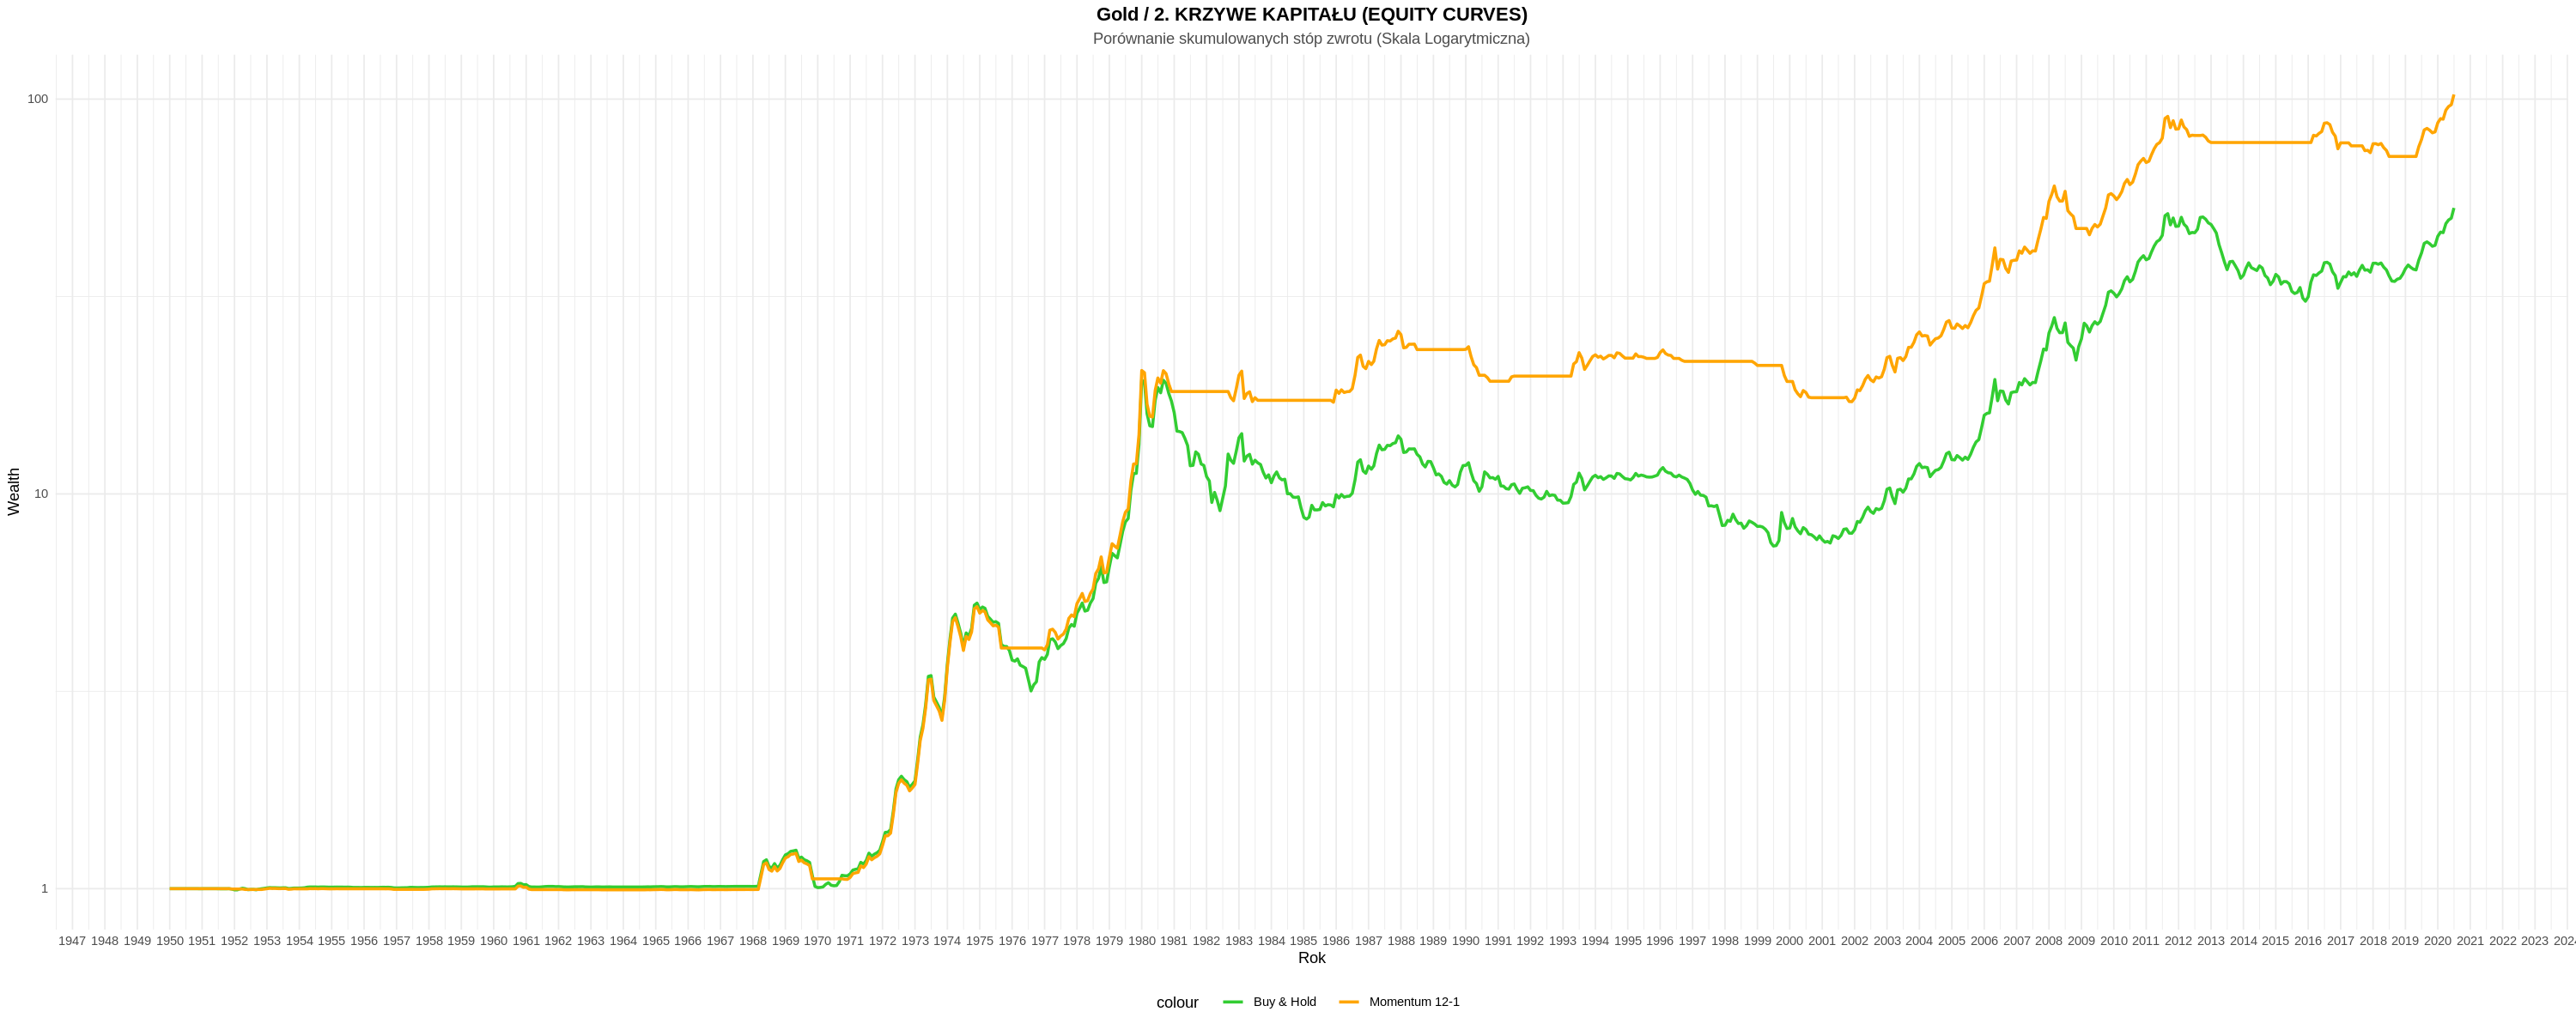

Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”


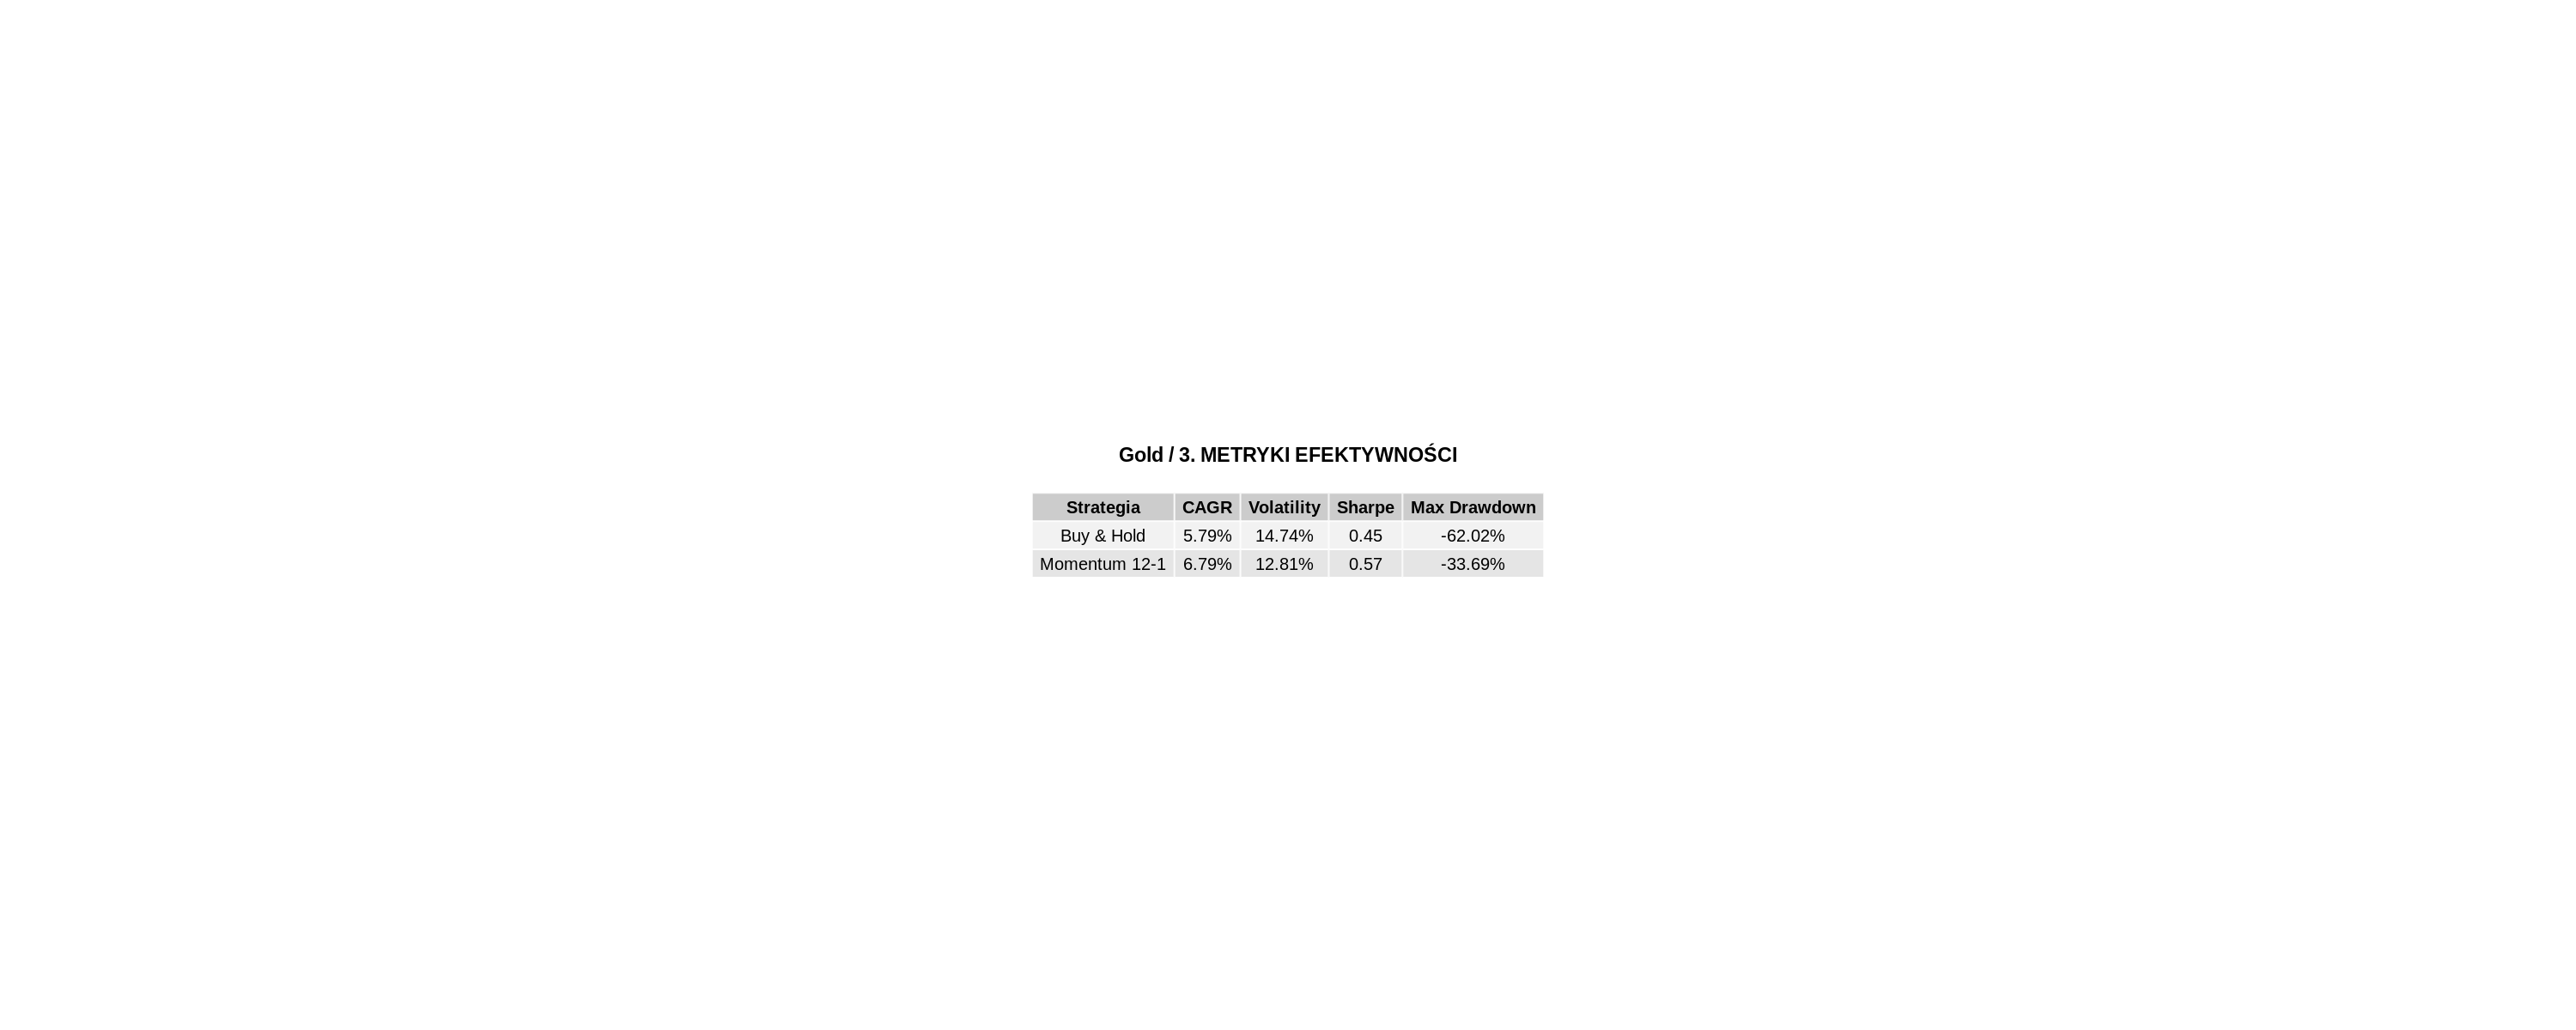


Szczegółowe wartości zwrotów rocznych:
 Year Buy&Hold Momentum12-1
 1950   -0.03%        0.00%
 1951   -0.17%       -0.20%
 1952    0.87%       -0.06%
 1953   -0.09%       -0.09%
 1954    0.52%        0.00%
 1955   -0.20%        0.03%
 1956   -0.26%       -0.34%
 1957    0.32%        0.06%
 1958    0.23%        0.23%
 1959   -0.06%       -0.06%
 1960    1.28%        0.97%
 1961   -1.15%       -1.35%
 1962   -0.23%       -0.09%
 1963    0.06%       -0.06%
 1964    0.11%        0.09%
 1965    0.00%       -0.06%
 1966    0.09%        0.09%
 1967    0.03%        0.03%
 1968   16.86%       16.86%
 1969  -16.79%      -11.44%
 1970    7.12%       -0.32%
 1971   14.75%       14.75%
 1972   39.74%       39.74%
 1973   63.12%       63.12%
 1974   42.36%       42.36%
 1975  -21.25%      -18.41%
 1976    1.50%        0.00%
 1977   21.29%       21.29%
 1978   20.03%       20.03%
 1979  104.27%      104.27%
 1980  -11.54%      -11.54%
 1981  -26.48%        0.00%
 1982   15.78%        1.51%
 1983  -

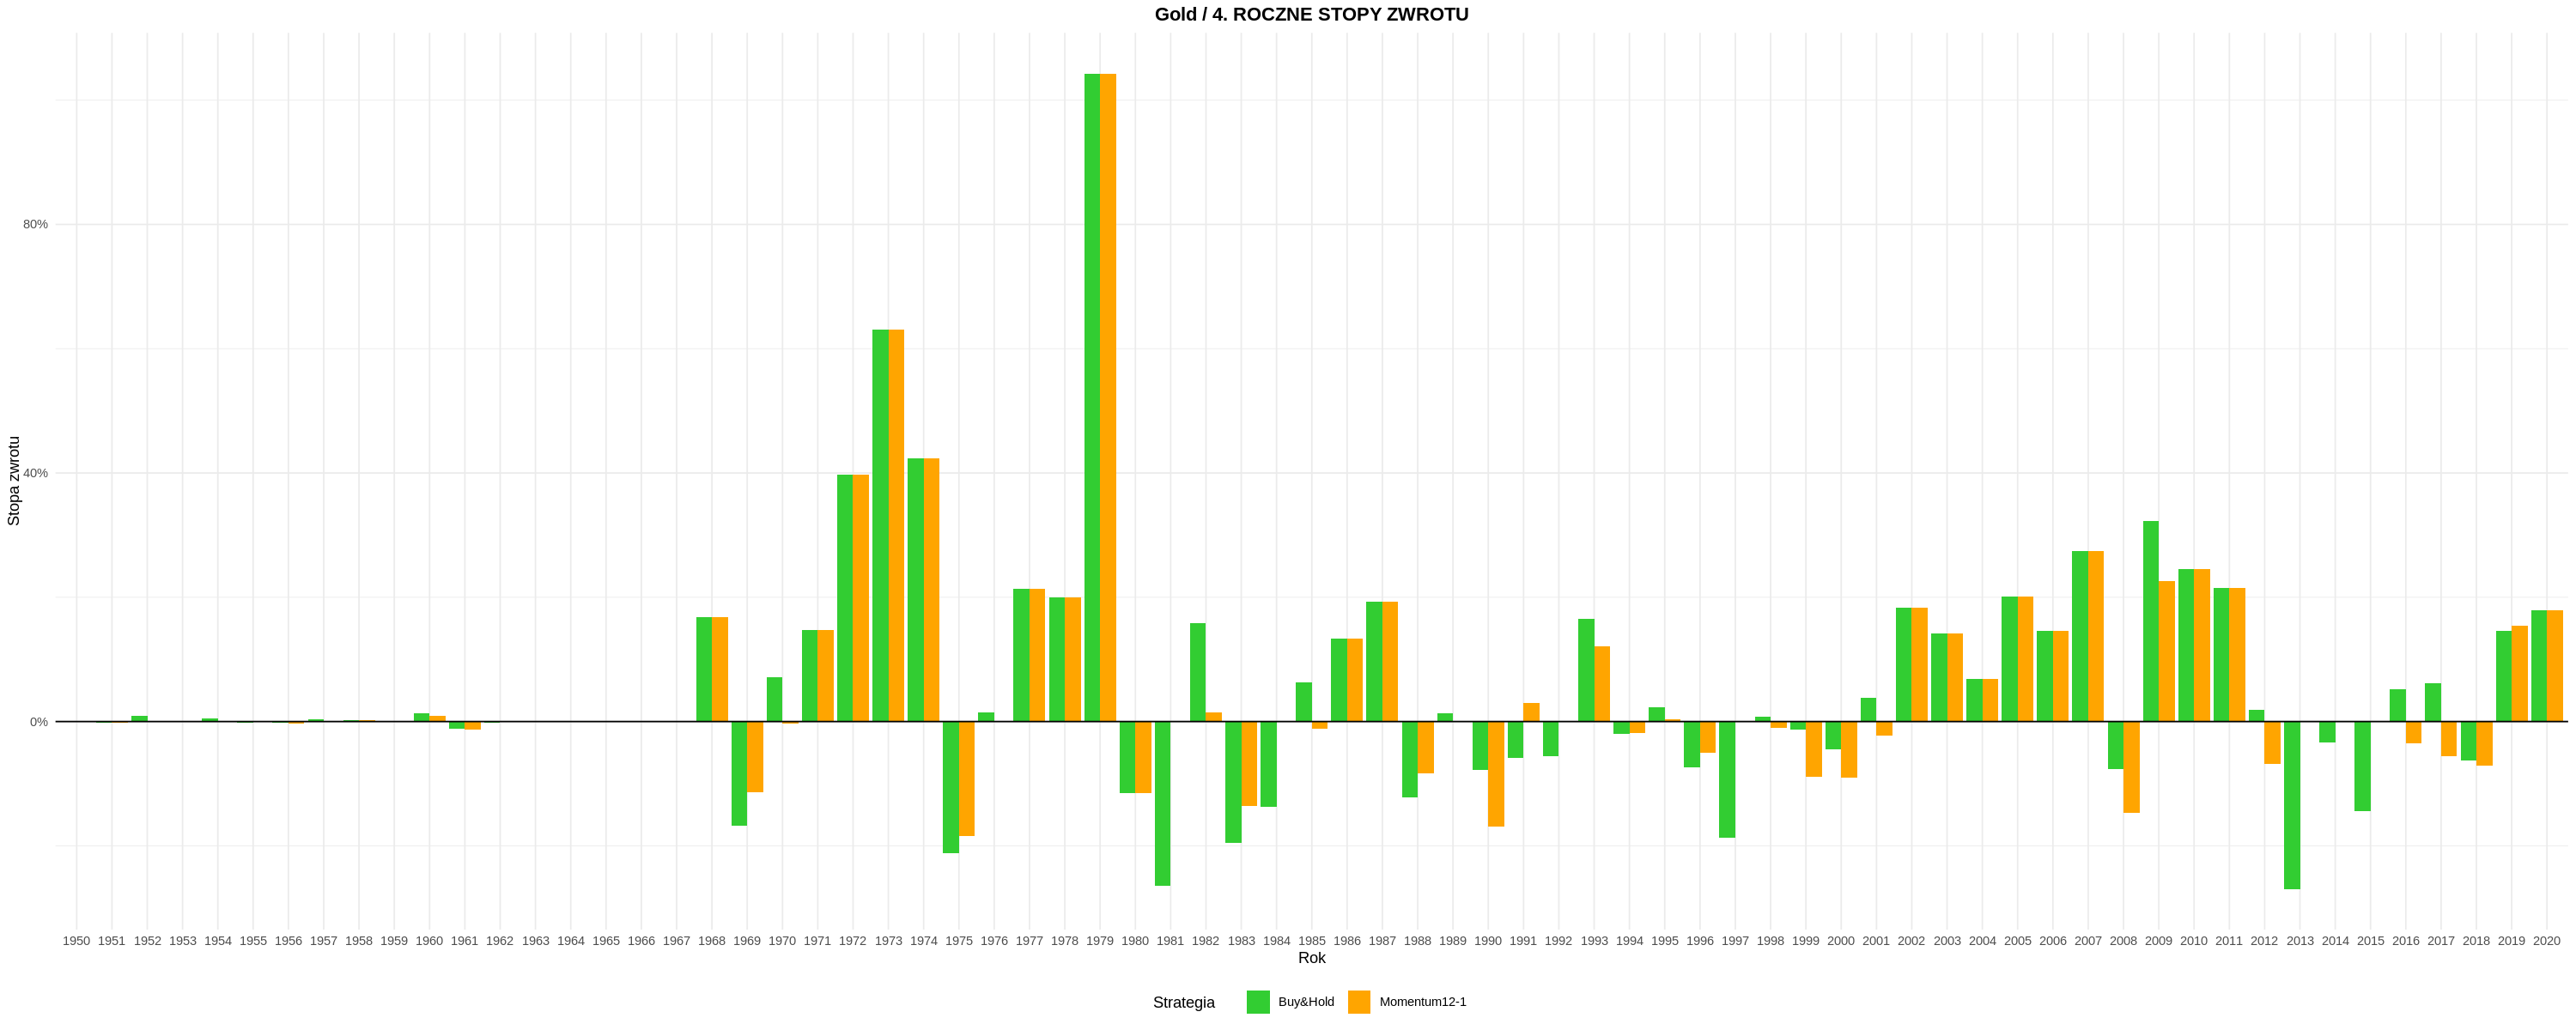

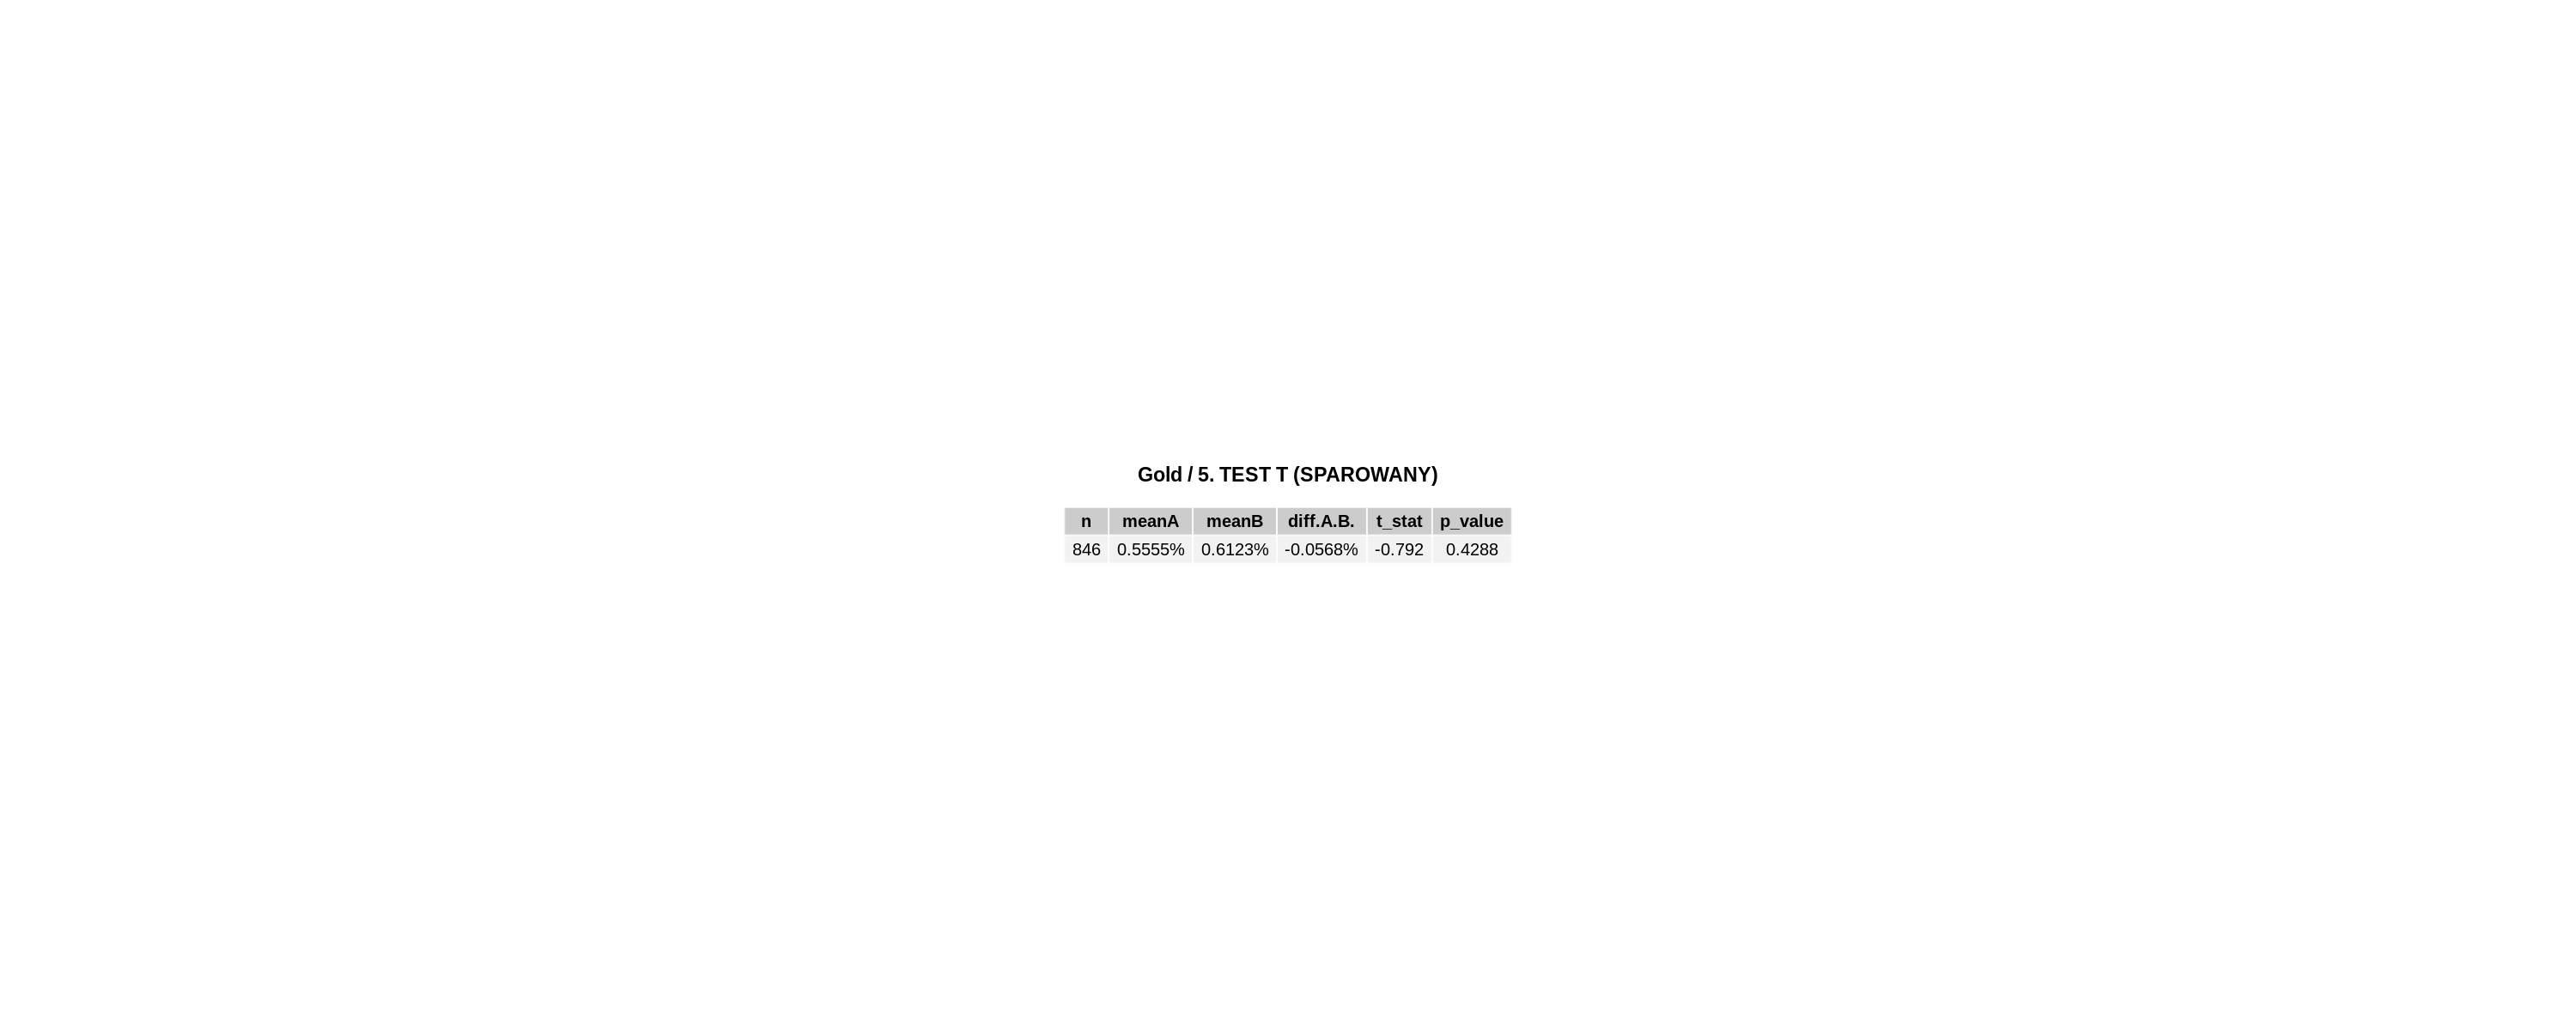

In [30]:
options(repr.plot.height = 10, repr.plot.width = 25)
# <- jeśli chcemy pracować na pełnym zbiorze danych (od 1950), należy zmienić width na 25 i zmienną niżej na gold_raw, jeśli jednak zależy nam na czytelności możemy zmienić width na 10 i zmienną na gold_filtered

gold_results <- run_analysis(gold_raw, "Gold")

### S&P 500

Warning message in geom_point(color = "steelblue", linewidth = 1):
“Ignoring unknown parameters: `linewidth`”
Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”
Warning message in element_text(hjust = 0.5, linewidth = 11, color = "grey30"):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 11”
Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”
Warning message in element_text(hjust = 0.5, linewidth = 11, color = "grey30"):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 11”


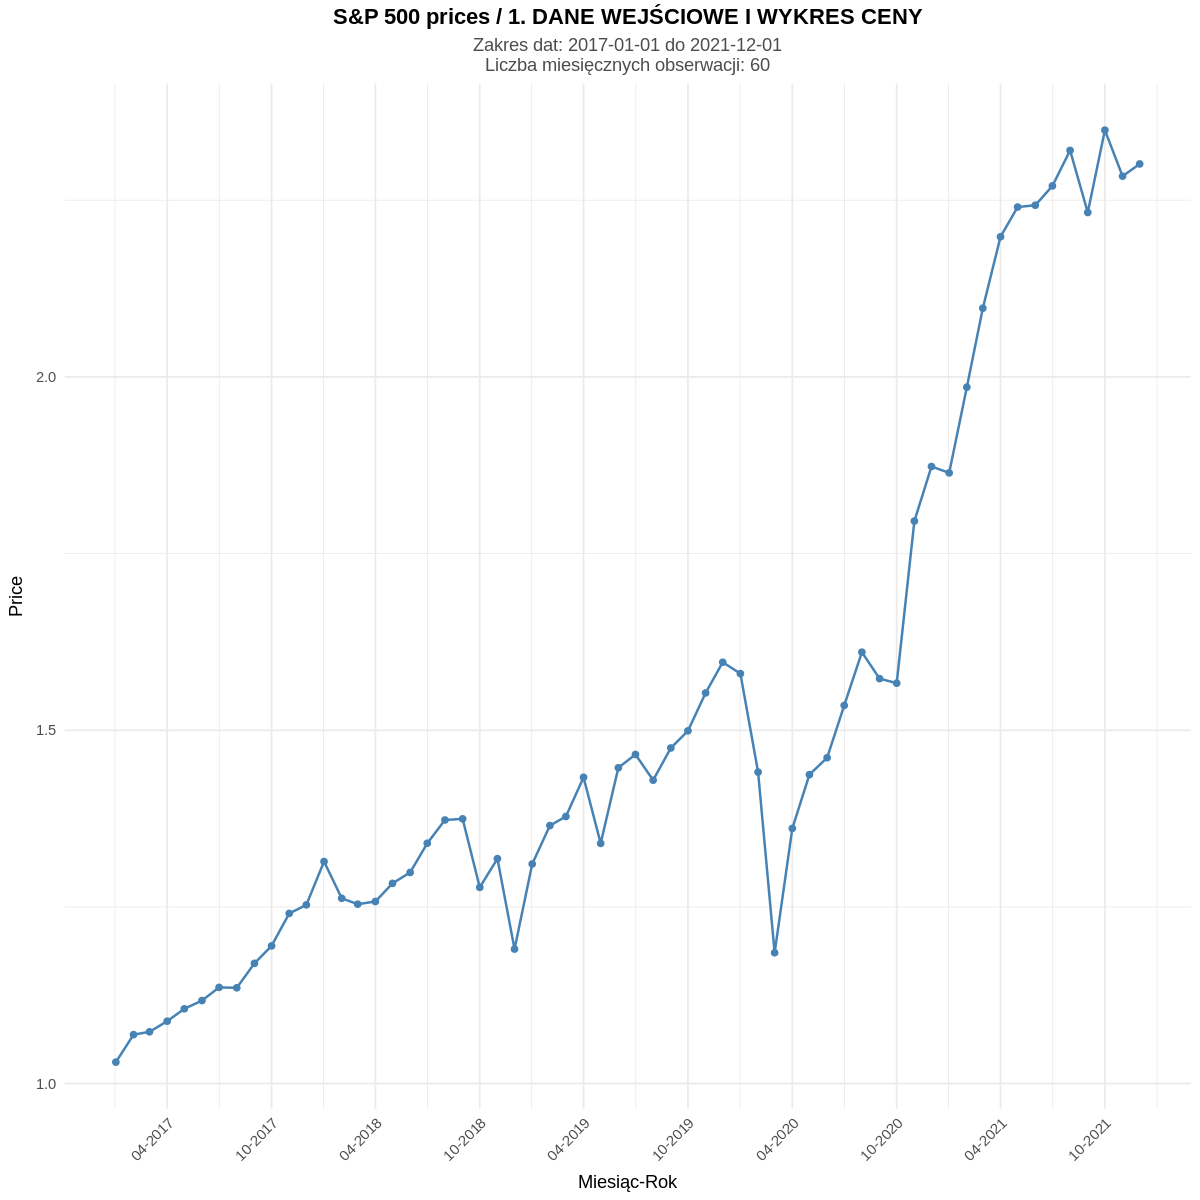

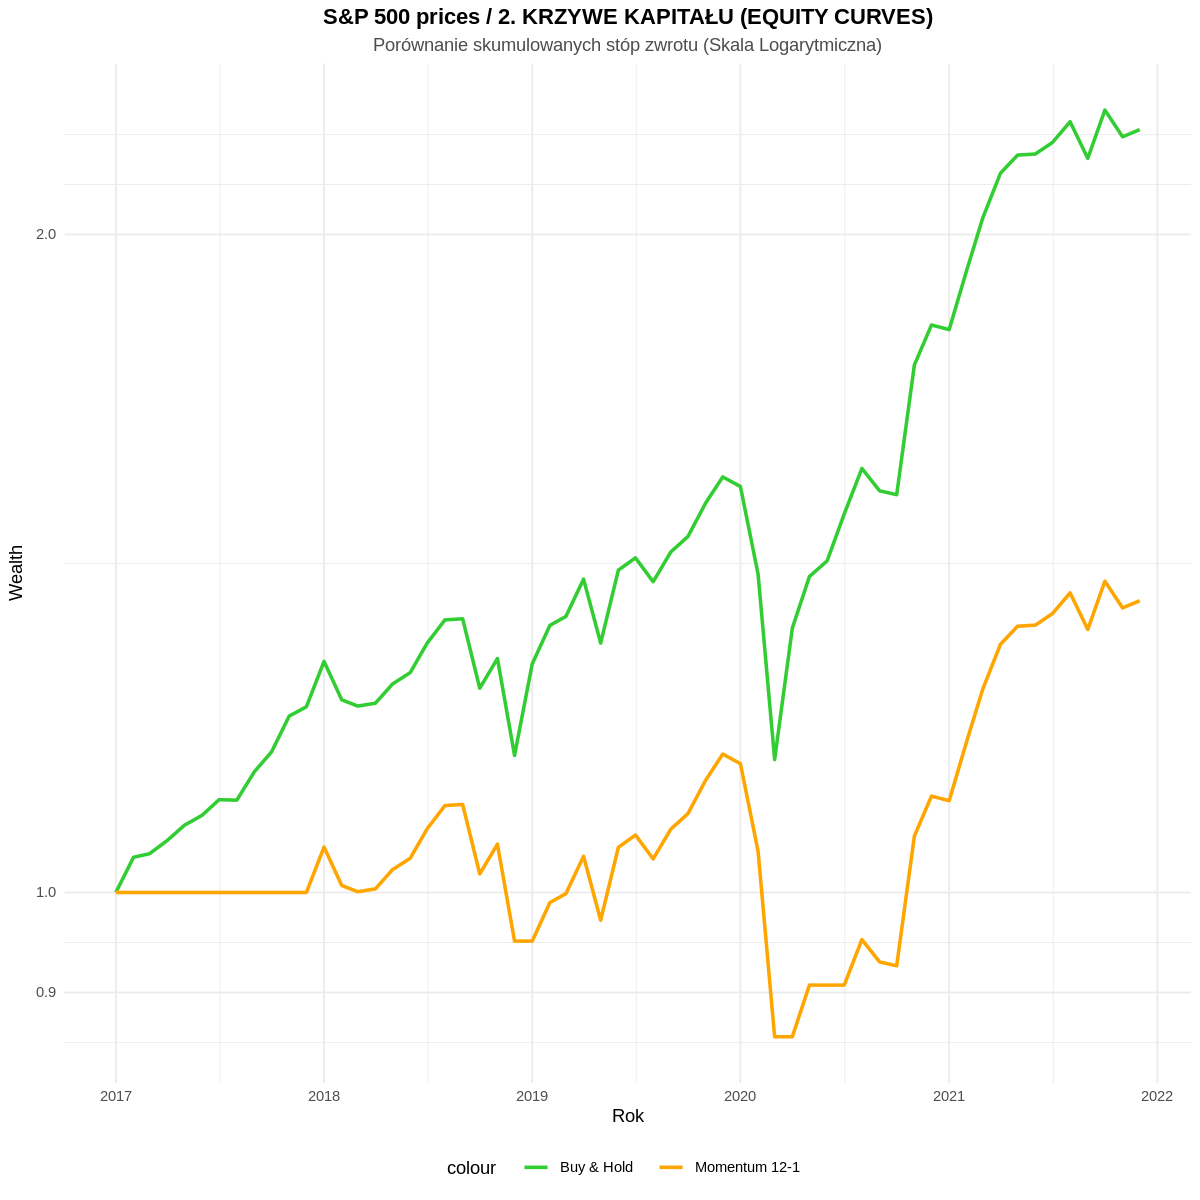

Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”


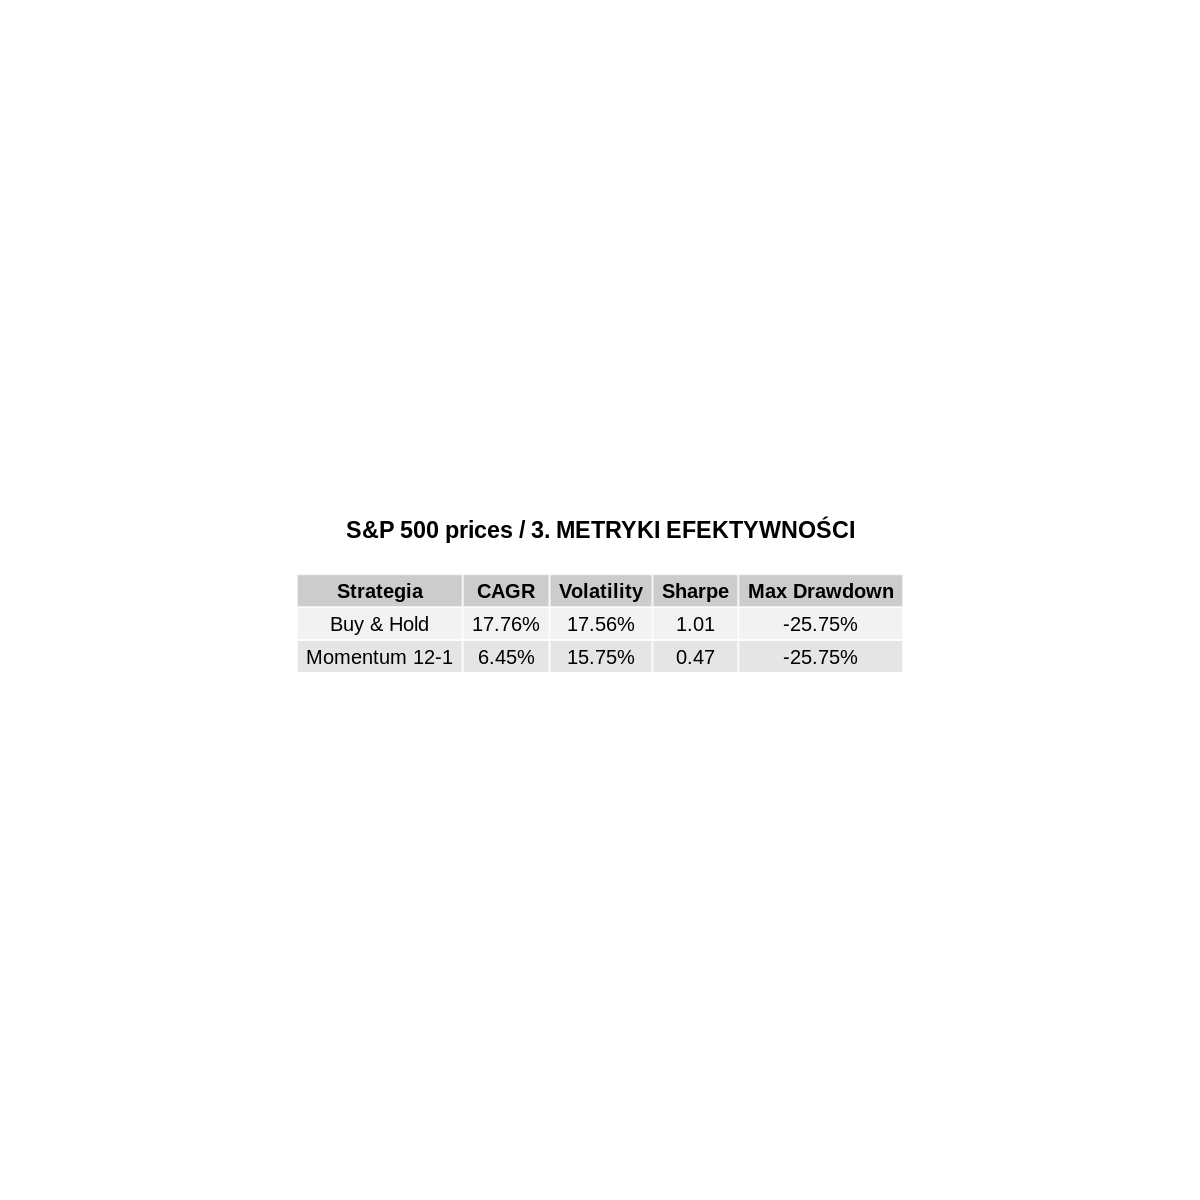


Szczegółowe wartości zwrotów rocznych:
 Year Buy&Hold Momentum12-1
 2017   21.60%        0.00%
 2018   -9.43%       -9.43%
 2019   21.78%       21.78%
 2020   18.55%       -3.36%
 2021   23.45%       23.45%



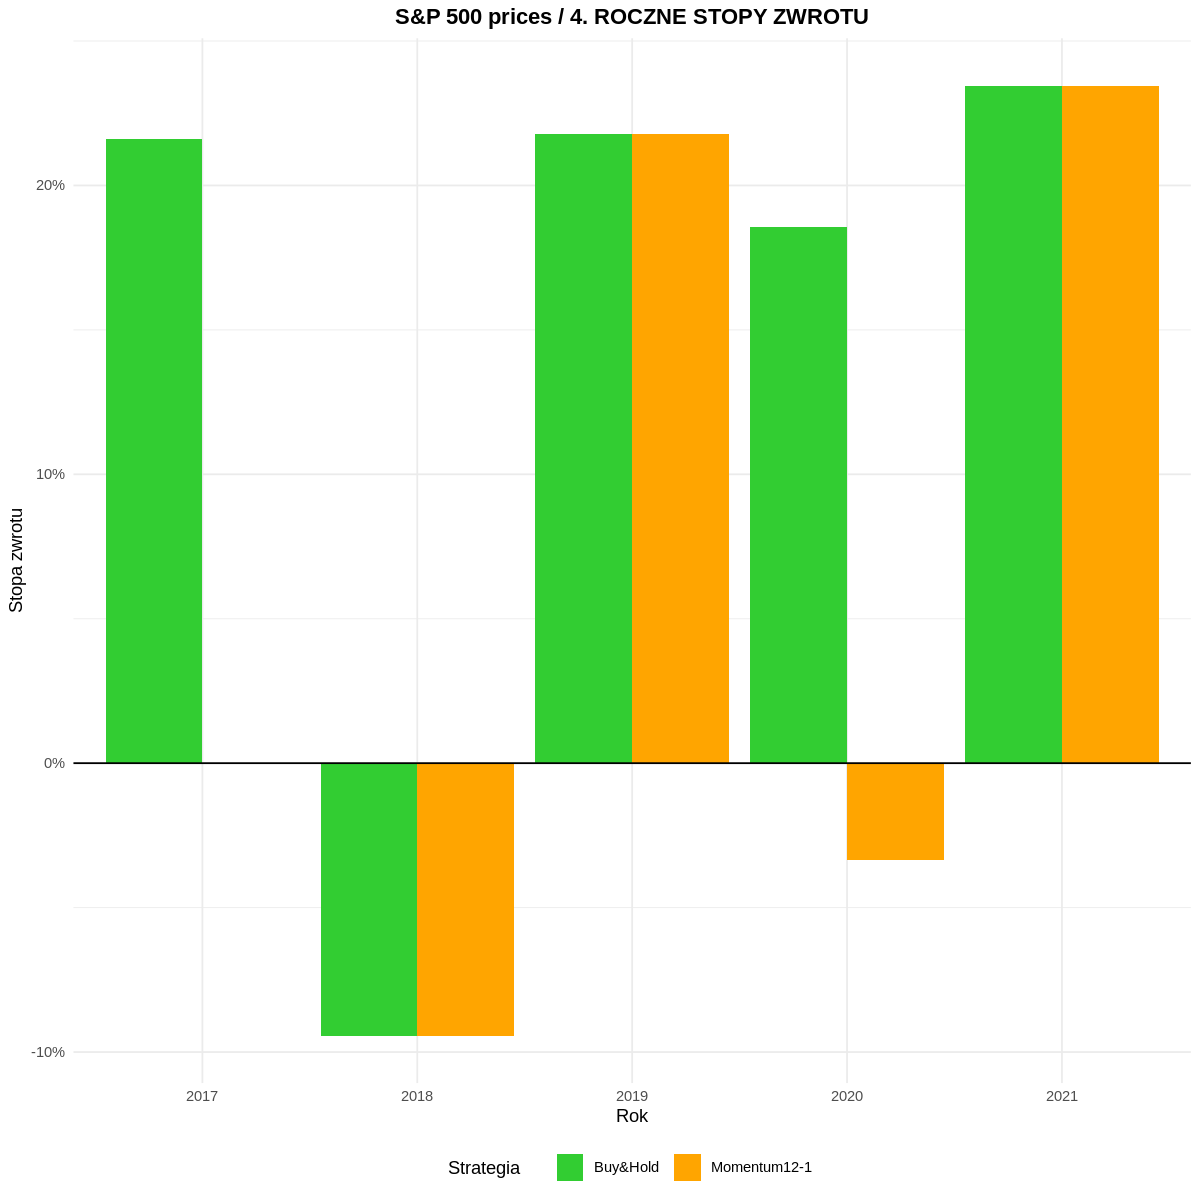

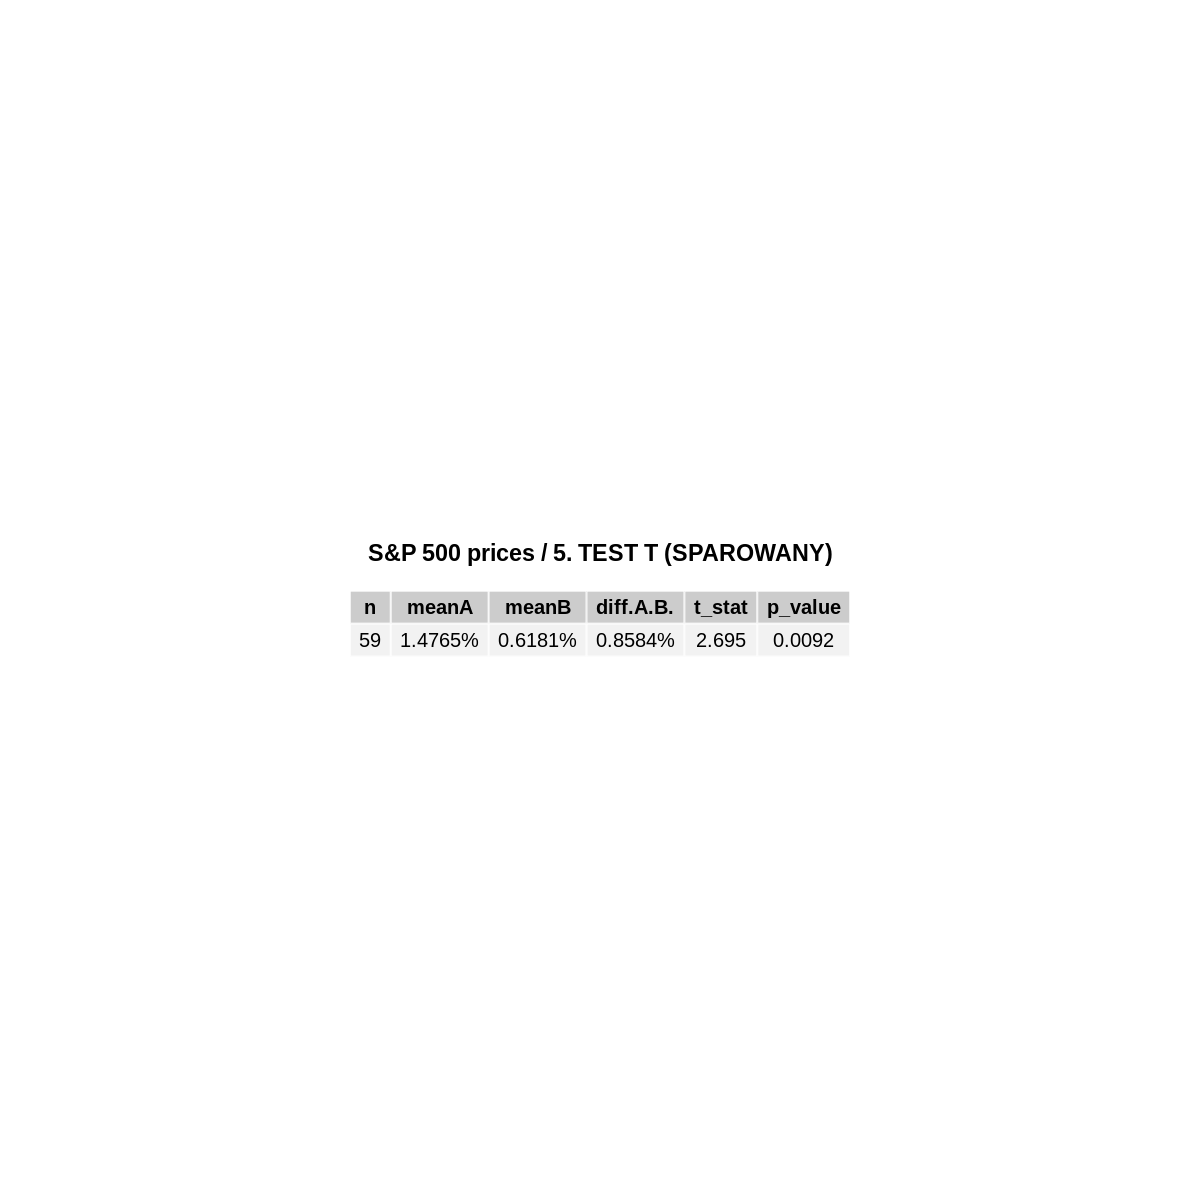

In [31]:
options(repr.plot.height = 10, repr.plot.width = 10)
sp500_results <- run_analysis(SP500_prices_m, "S&P 500 prices")

### Kryptowaluty

Warning message in geom_point(color = "steelblue", linewidth = 1):
“Ignoring unknown parameters: `linewidth`”
Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”
Warning message in element_text(hjust = 0.5, linewidth = 11, color = "grey30"):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 11”
Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”
Warning message in element_text(hjust = 0.5, linewidth = 11, color = "grey30"):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 11”


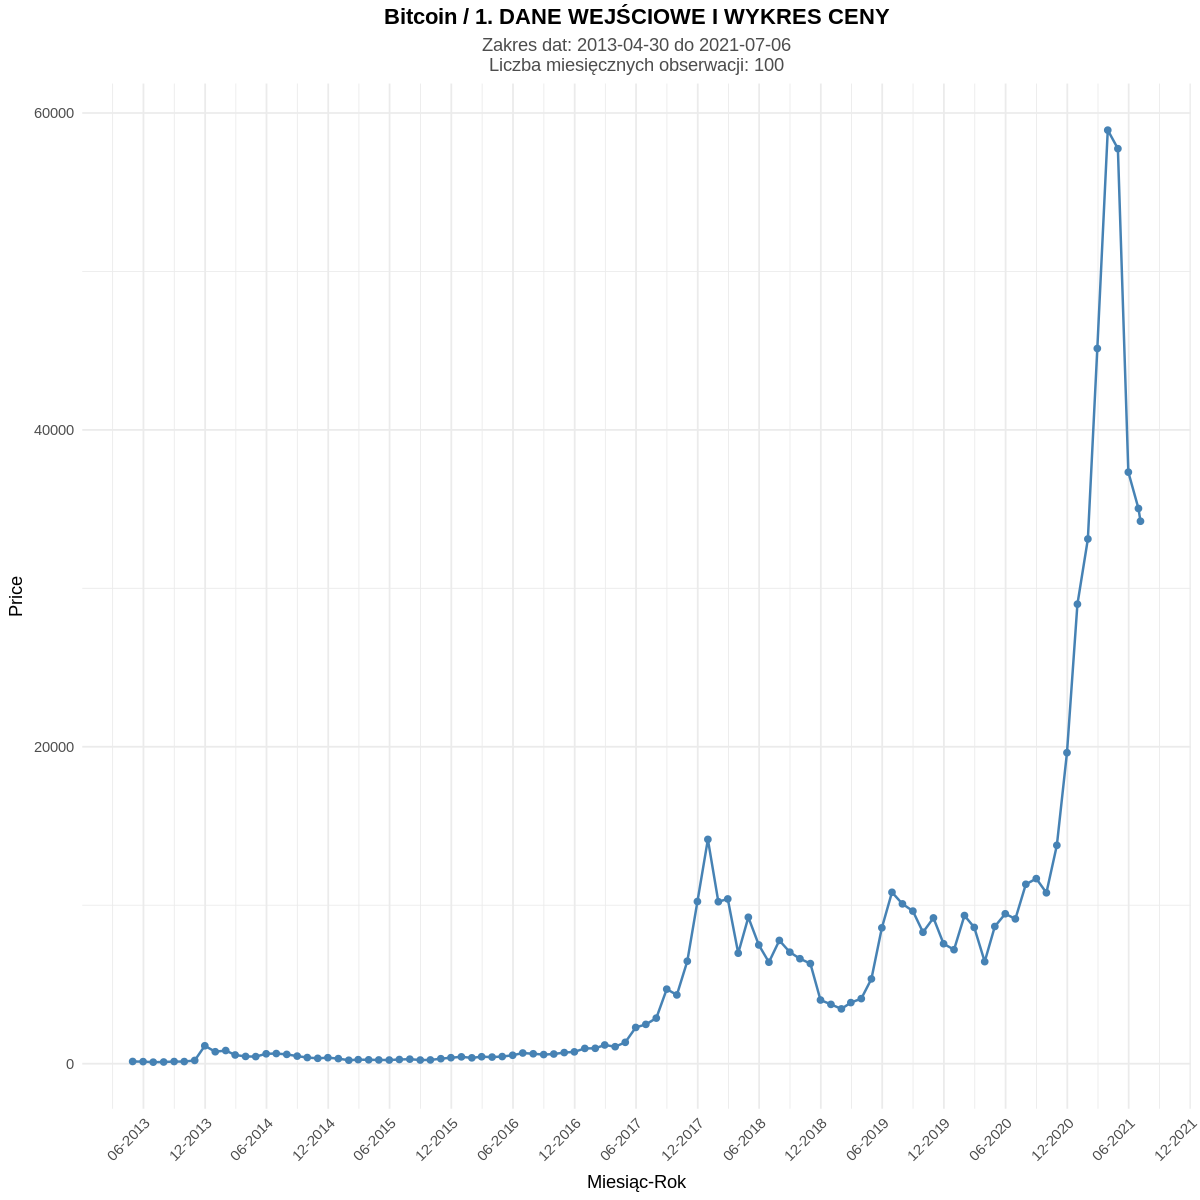

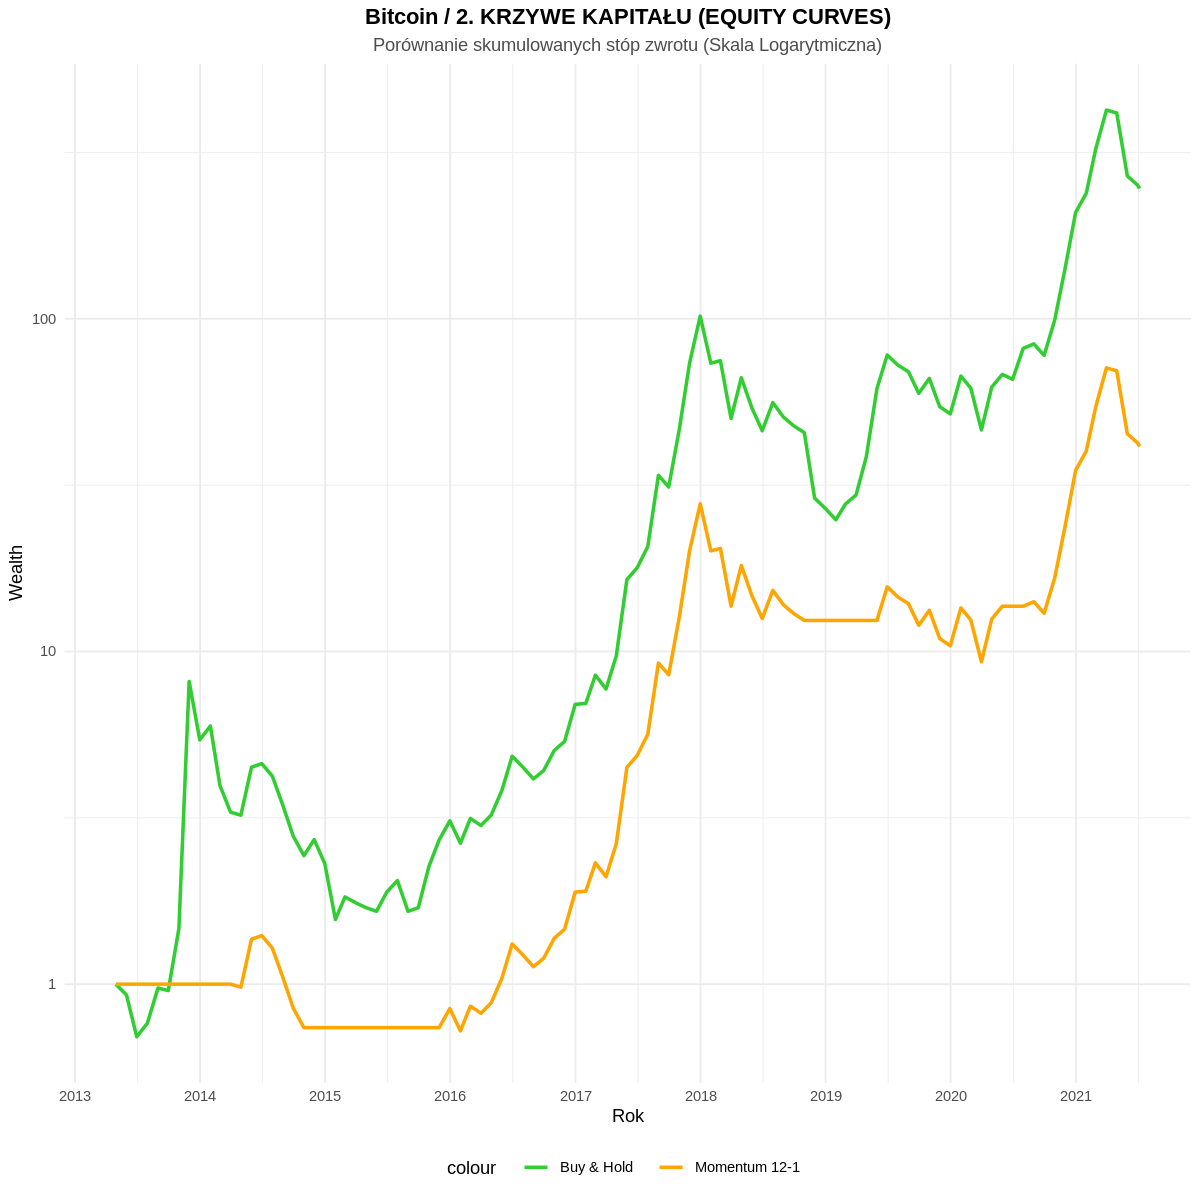

Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”


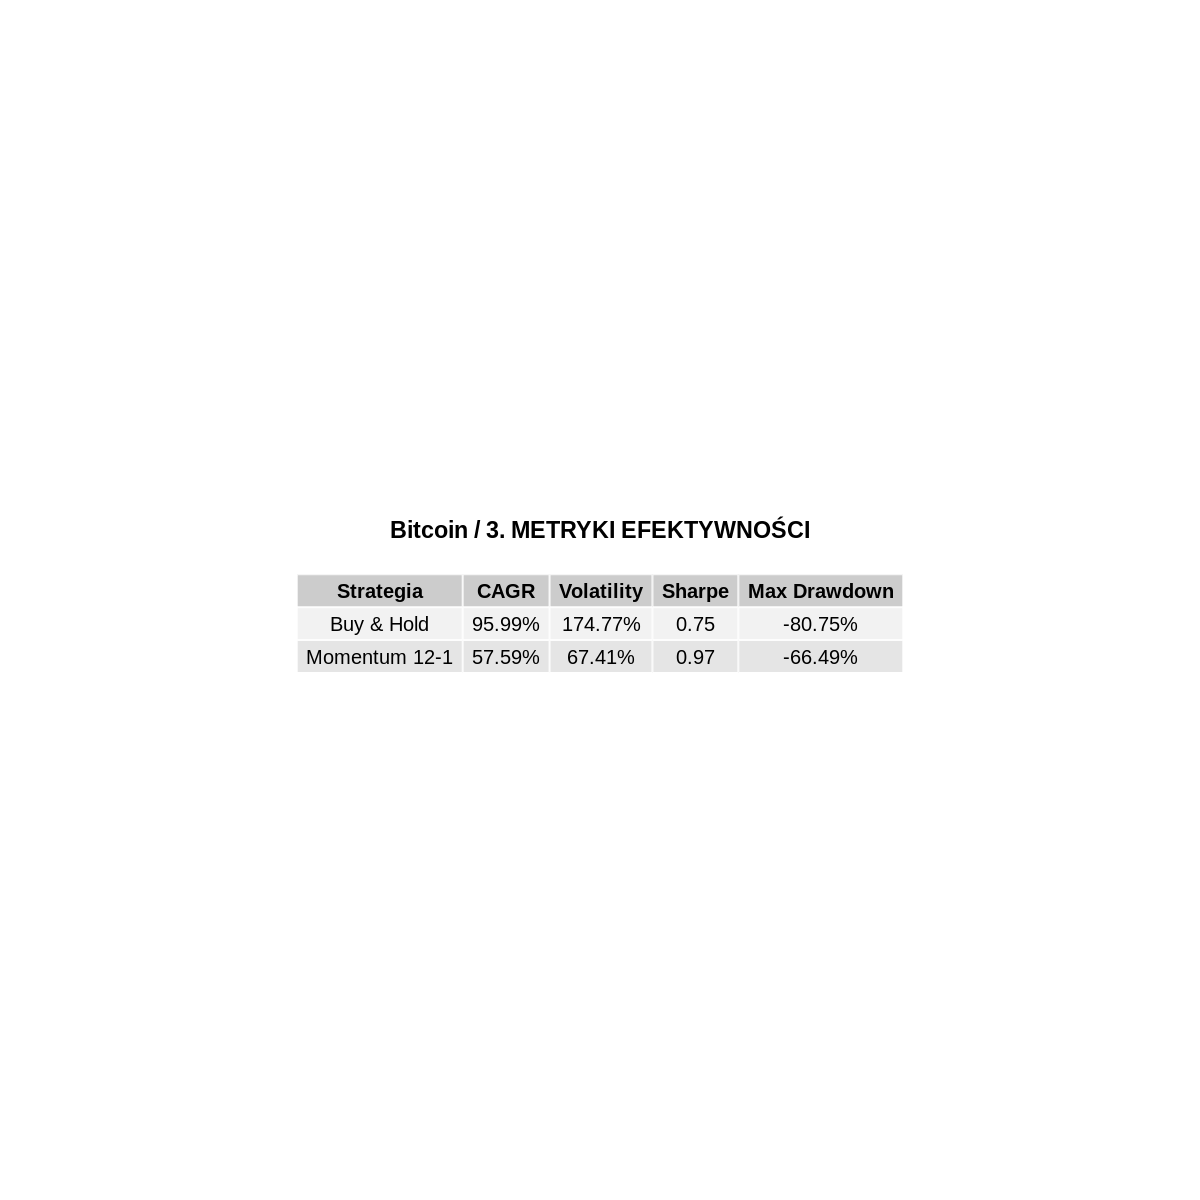


Szczegółowe wartości zwrotów rocznych:
 Year  Buy&Hold Momentum12-1
 2013   442.45%        0.00%
 2014   -61.42%      -25.97%
 2015    97.99%       14.11%
 2016   161.34%      161.34%
 2017 1 358.82%    1 358.82%
 2018   -63.38%      -38.19%
 2019   108.04%      -16.10%
 2020   210.16%      159.15%
 2021     3.38%        3.38%



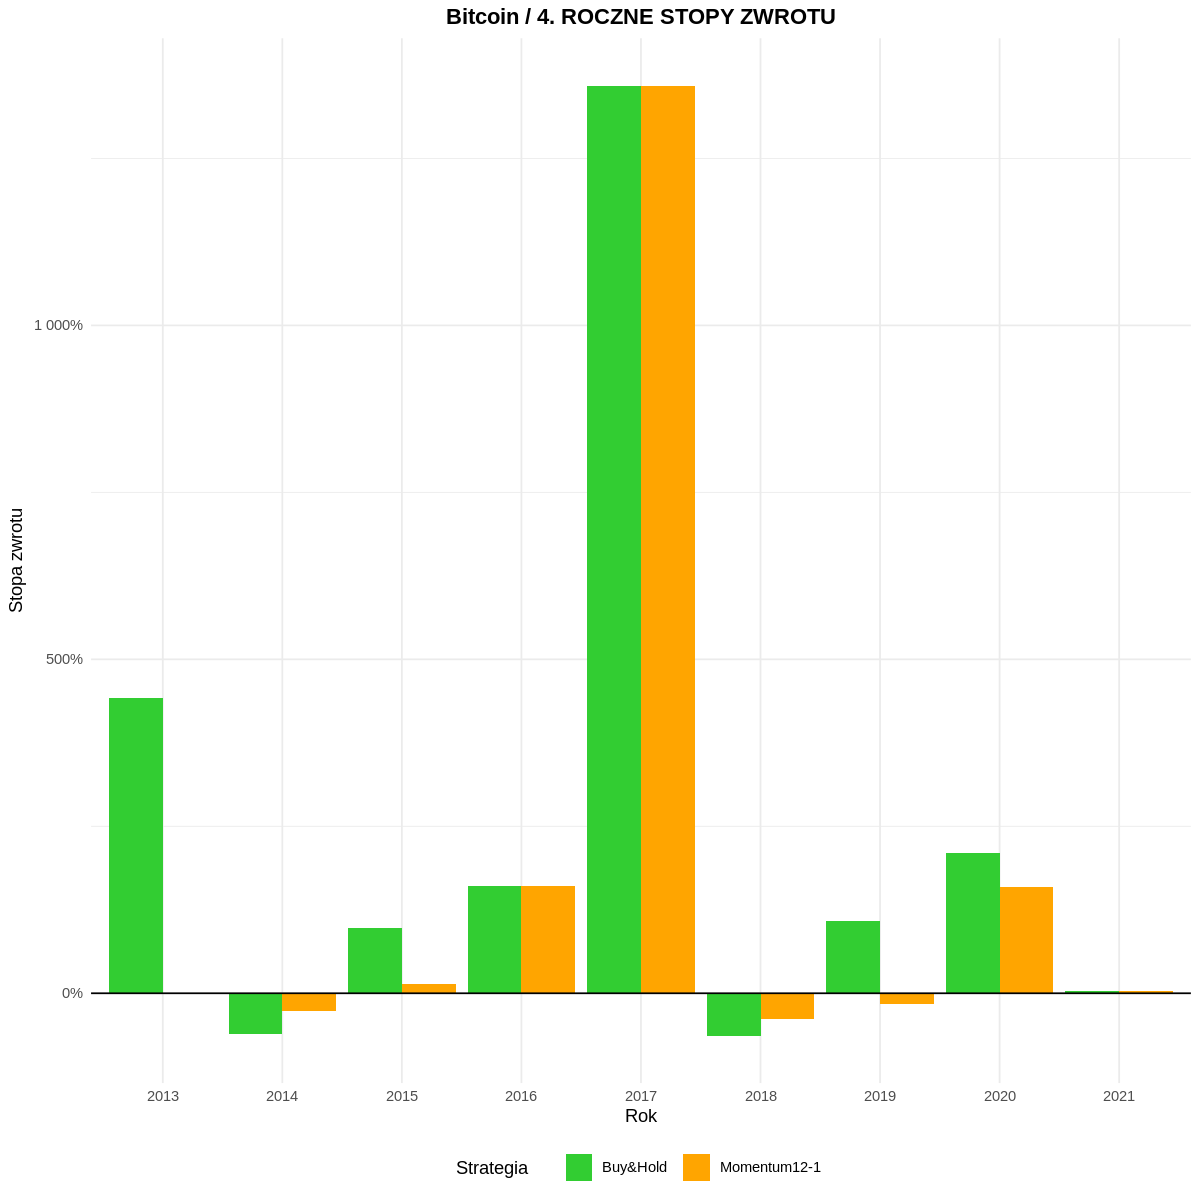

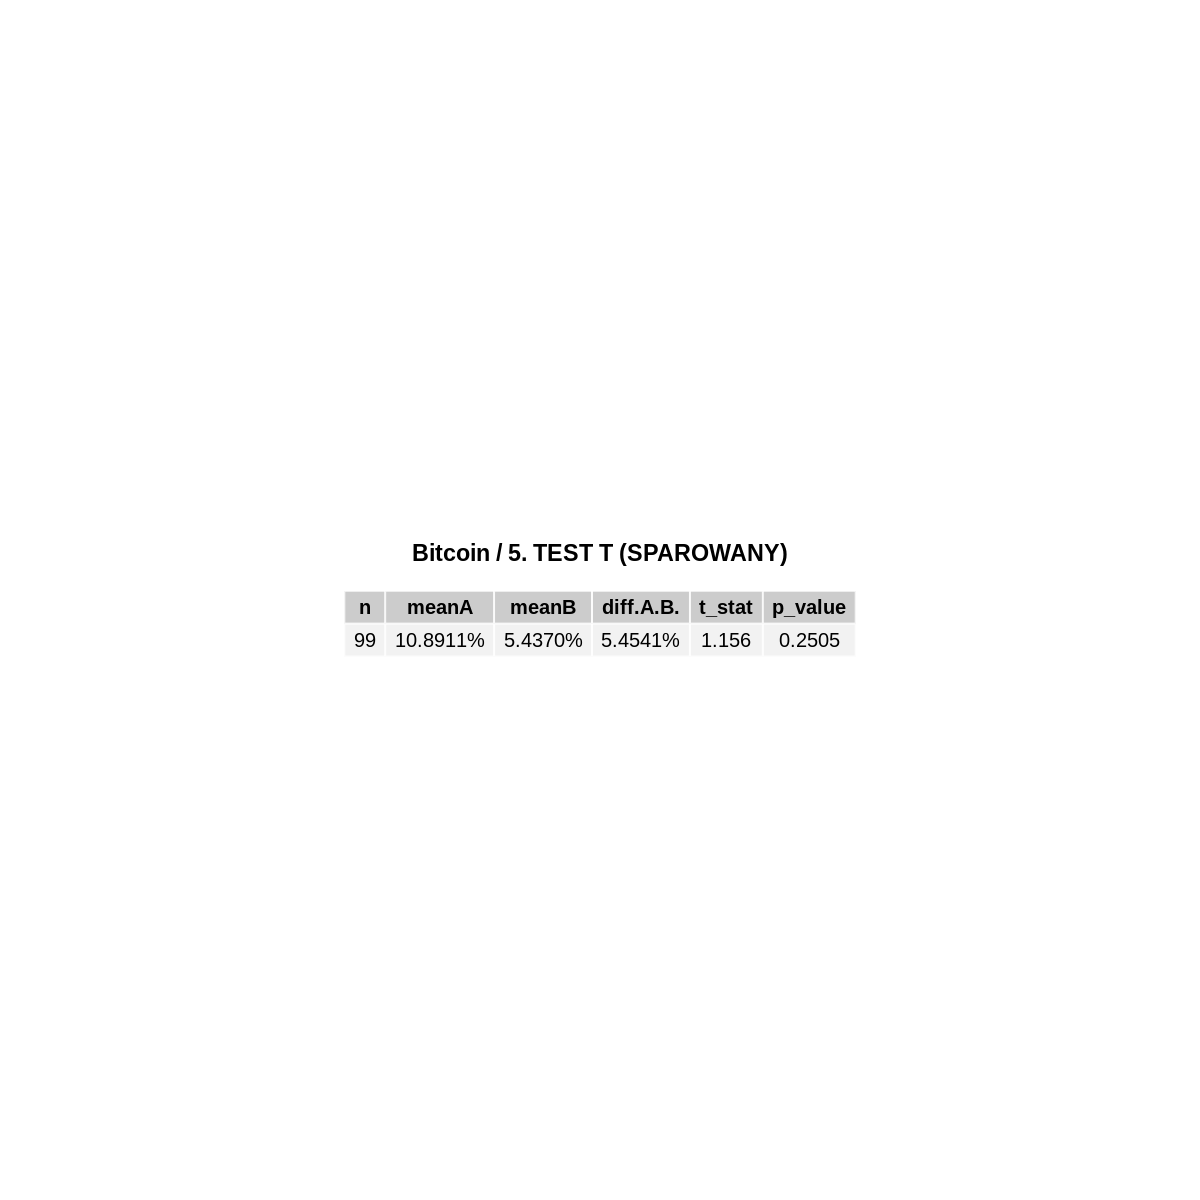

In [32]:
options(repr.plot.height = 10, repr.plot.width = 10)
# BITCOIN
results_btc <- run_analysis(BTC_prices_m, "Bitcoin")

Warning message in geom_point(color = "steelblue", linewidth = 1):
“Ignoring unknown parameters: `linewidth`”
Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”
Warning message in element_text(hjust = 0.5, linewidth = 11, color = "grey30"):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 11”
Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”
Warning message in element_text(hjust = 0.5, linewidth = 11, color = "grey30"):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 11”


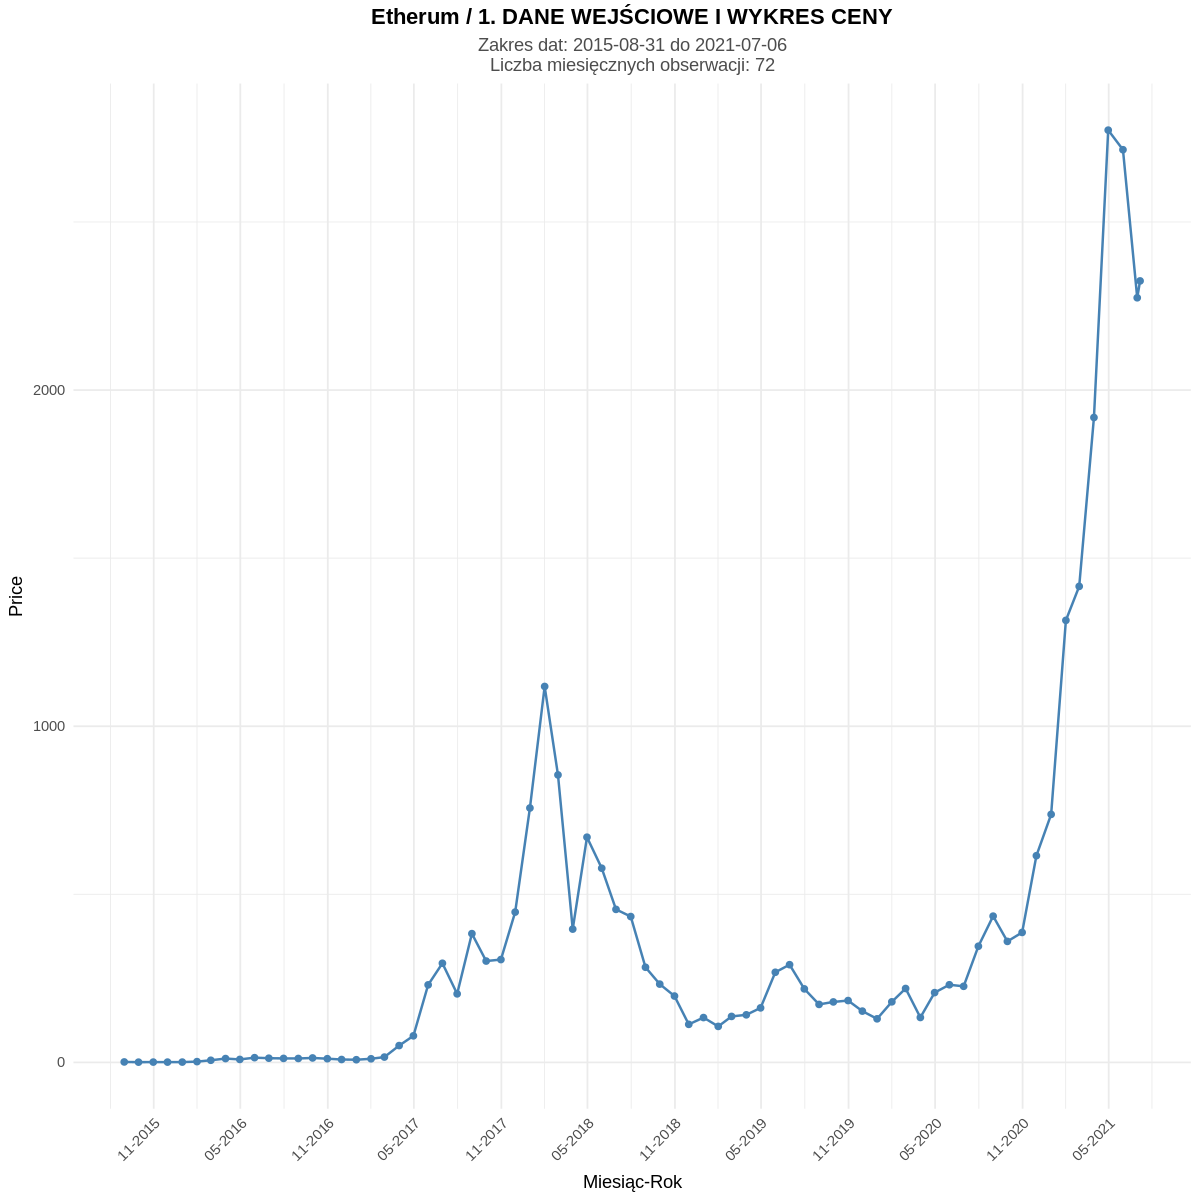

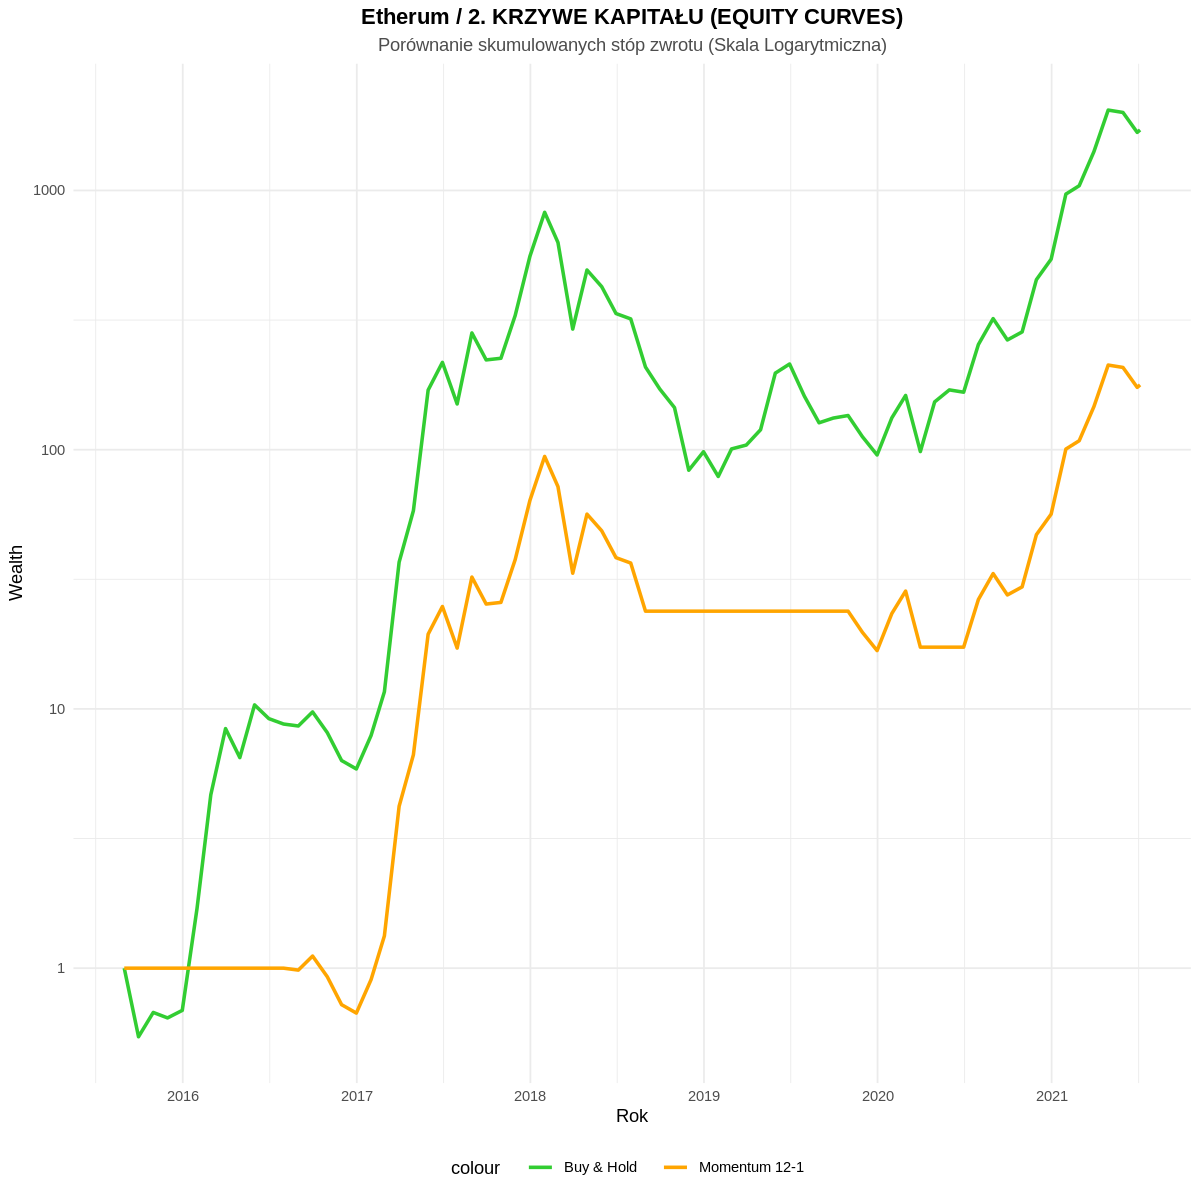

Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”


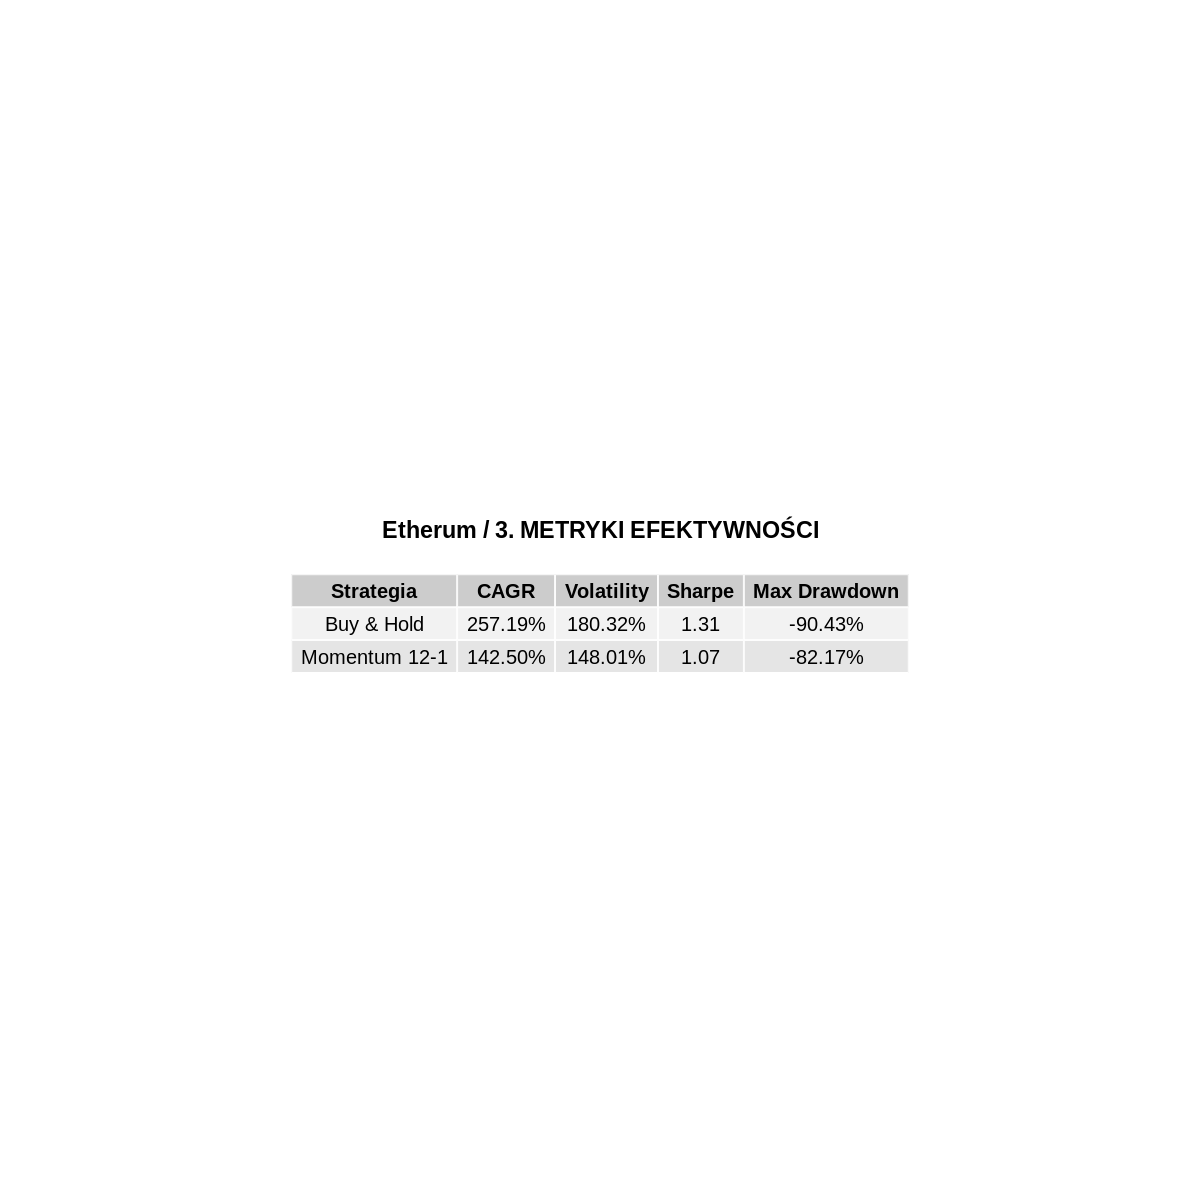


Szczegółowe wartości zwrotów rocznych:
 Year  Buy&Hold Momentum12-1
 2015   -31.27%        0.00%
 2016   245.58%      -32.90%
 2017 6 954.14%    6 954.14%
 2018   -88.07%      -74.69%
 2019    21.06%      -29.55%
 2020   309.53%      141.74%
 2021    76.78%       76.78%



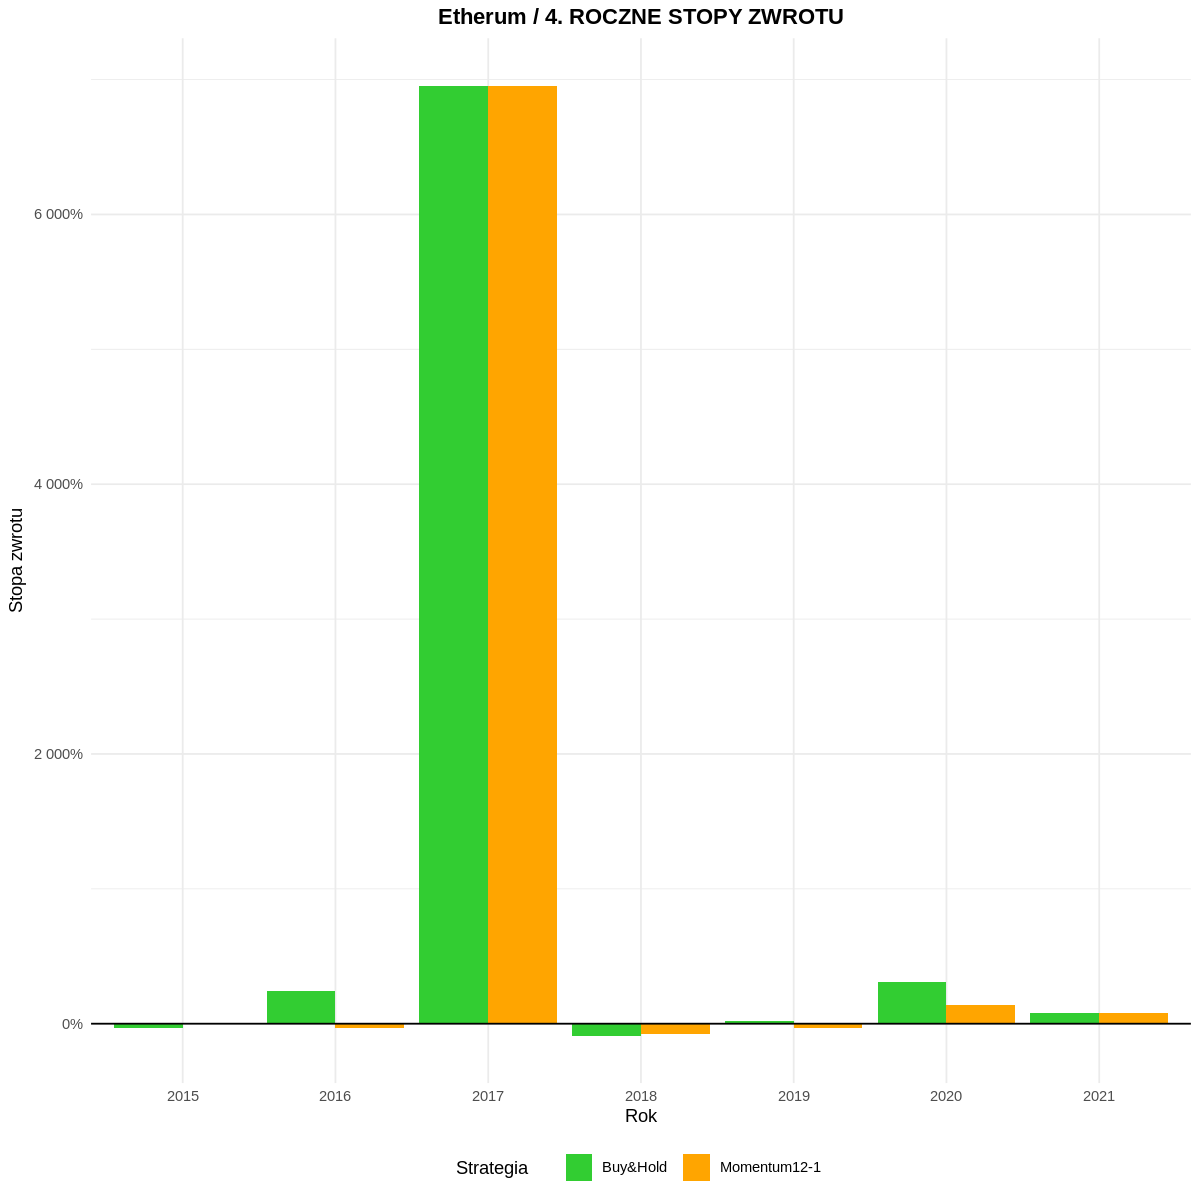

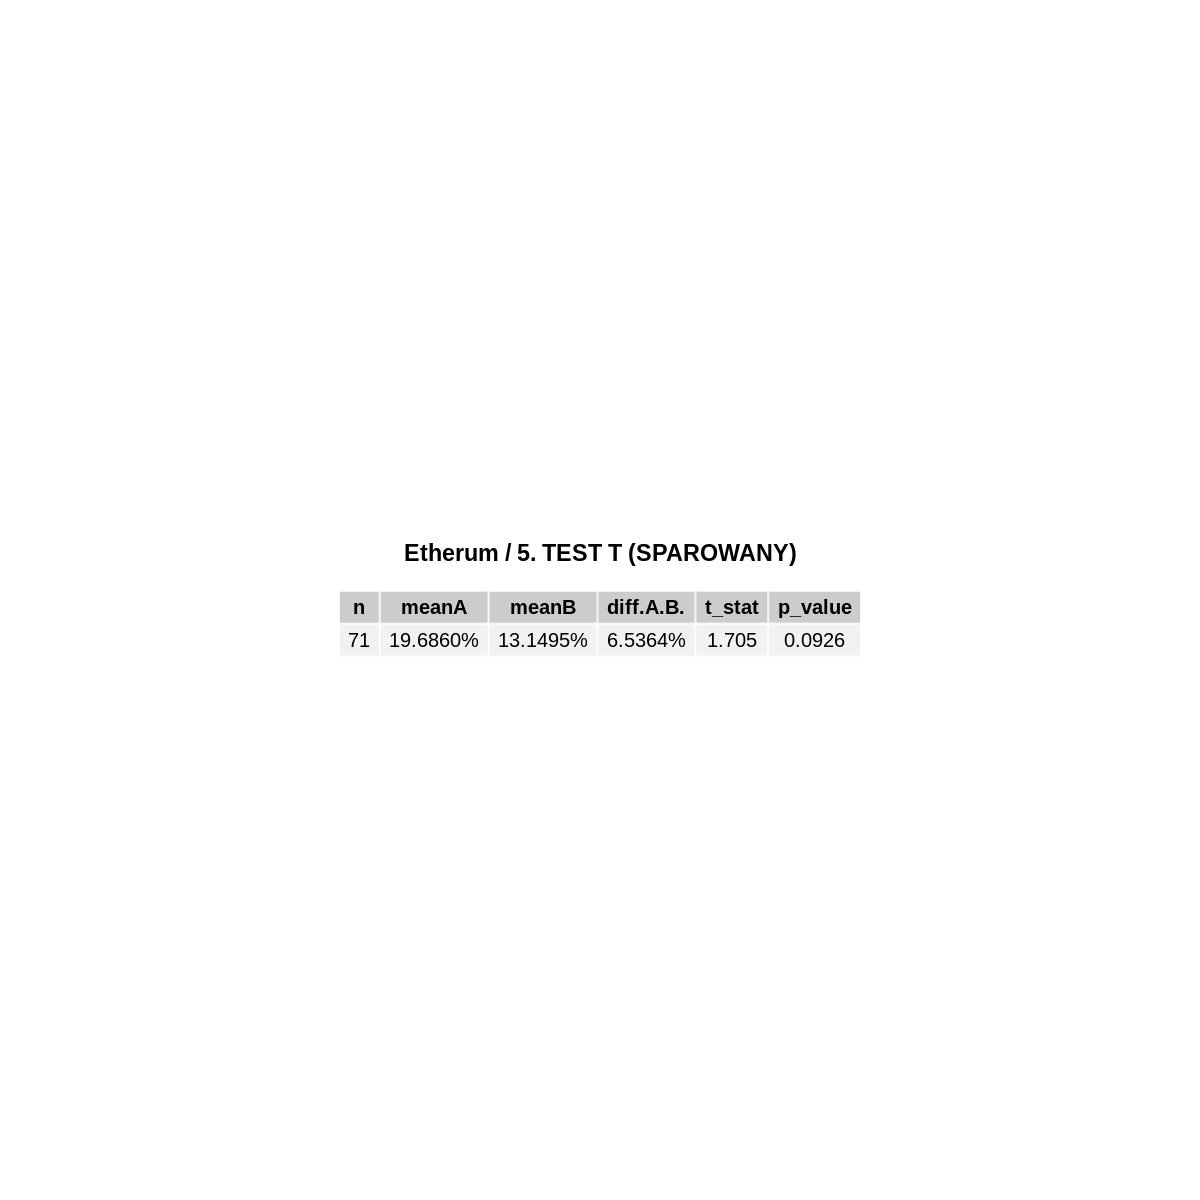

In [33]:
options(repr.plot.height = 10, repr.plot.width = 10)
# ETHERUM
results_eth <- run_analysis(ETH_prices_m, "Etherum")

Warning message in geom_point(color = "steelblue", linewidth = 1):
“Ignoring unknown parameters: `linewidth`”
Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”
Warning message in element_text(hjust = 0.5, linewidth = 11, color = "grey30"):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 11”
Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”
Warning message in element_text(hjust = 0.5, linewidth = 11, color = "grey30"):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 11”


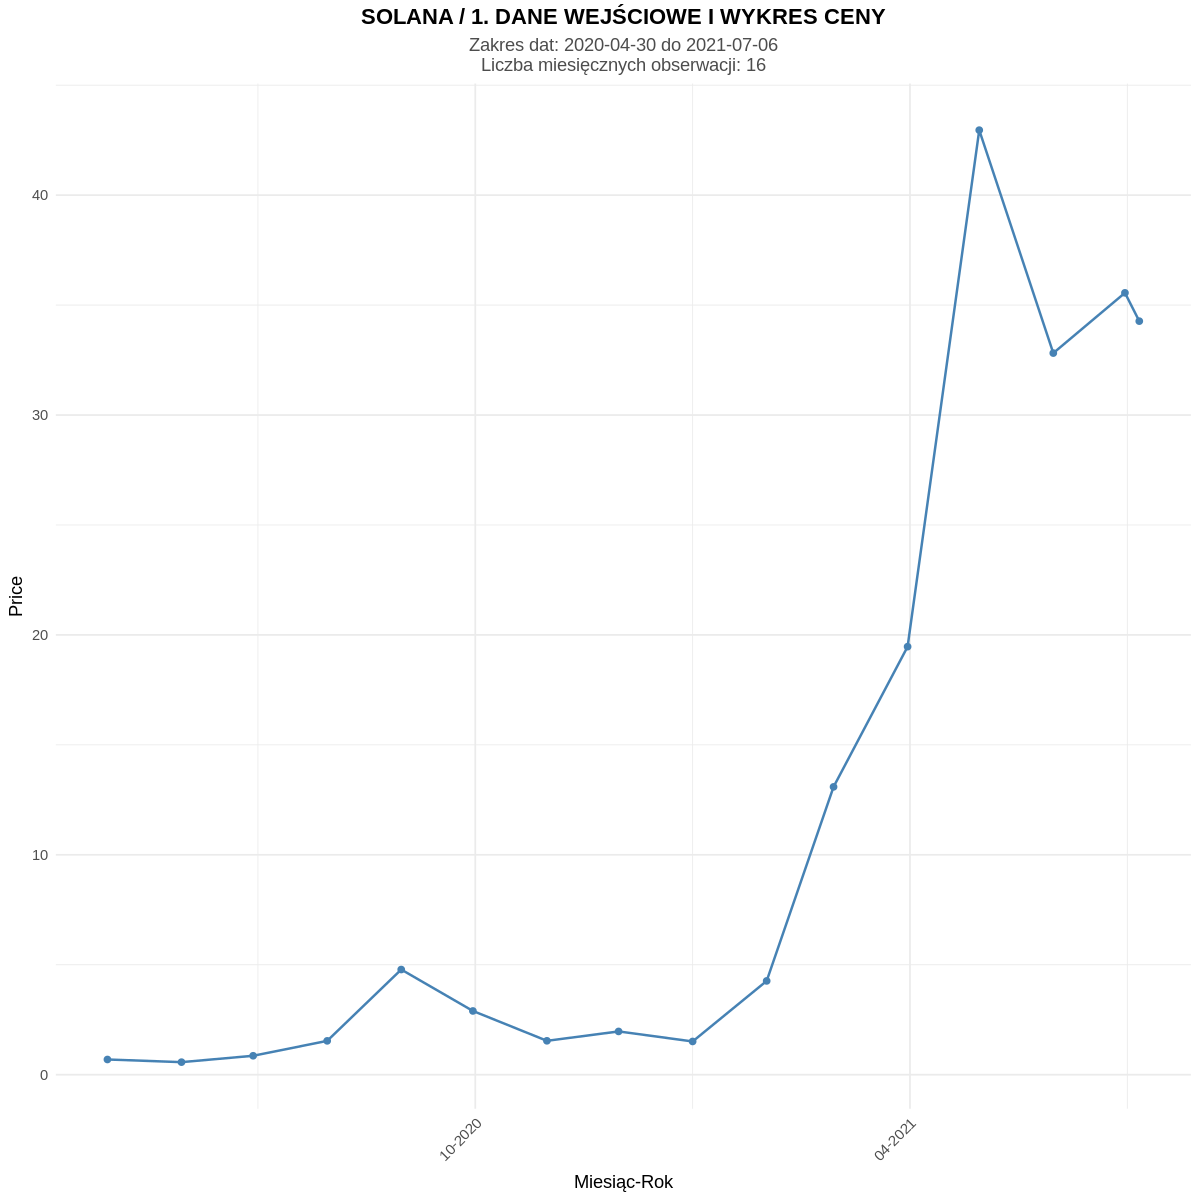

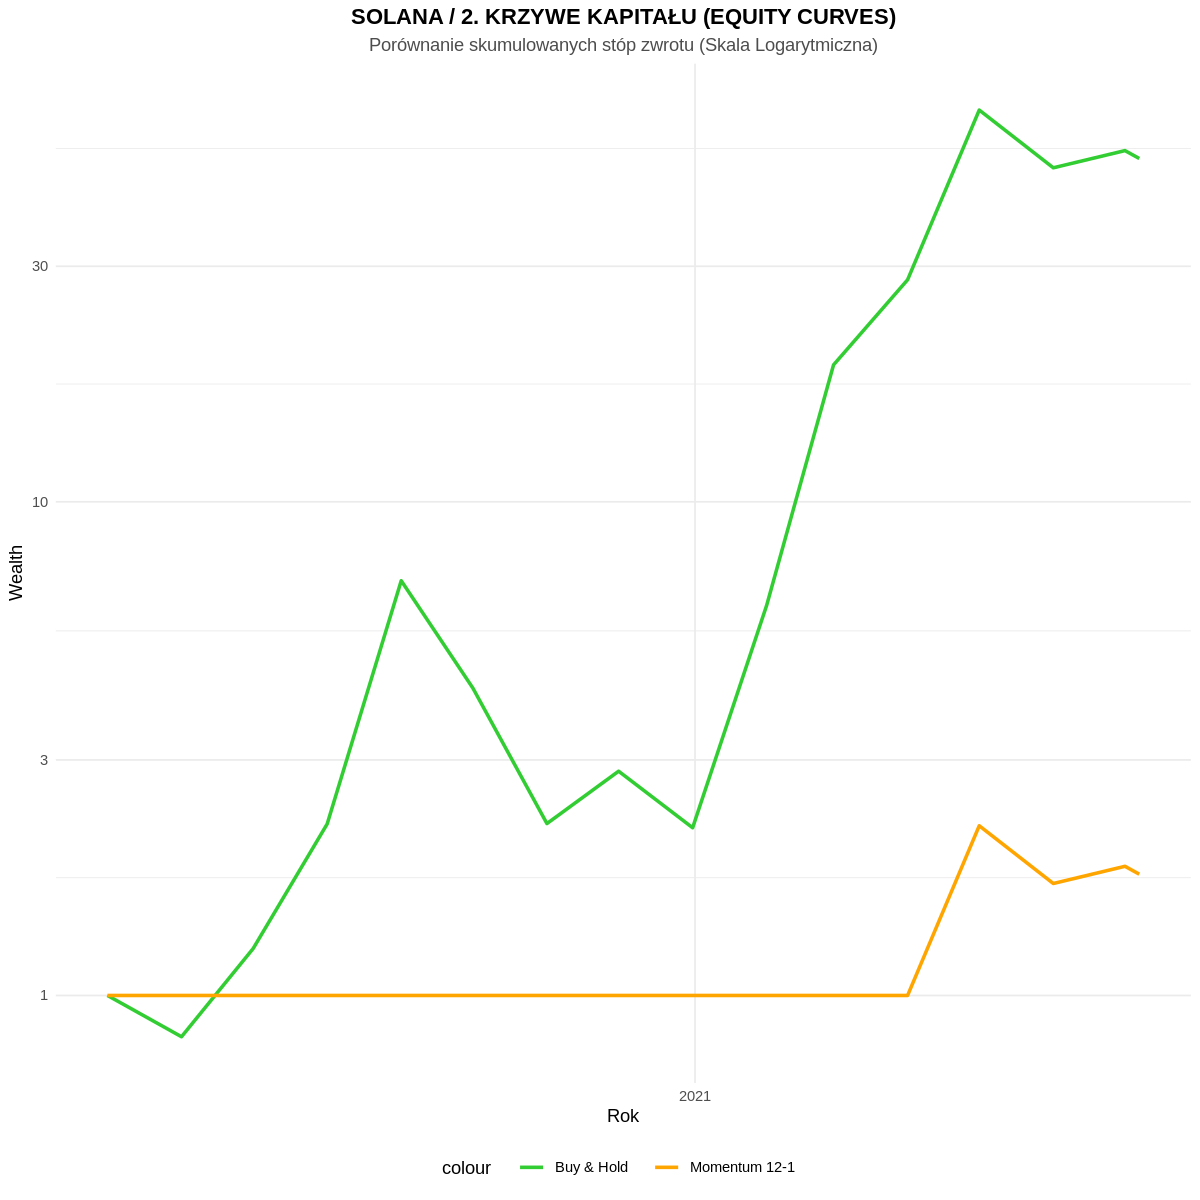

Warning message in element_text(hjust = 0.5, face = "bold", linewidth = 14):
“`...` must be empty.
✖ Problematic argument:
• linewidth = 14”


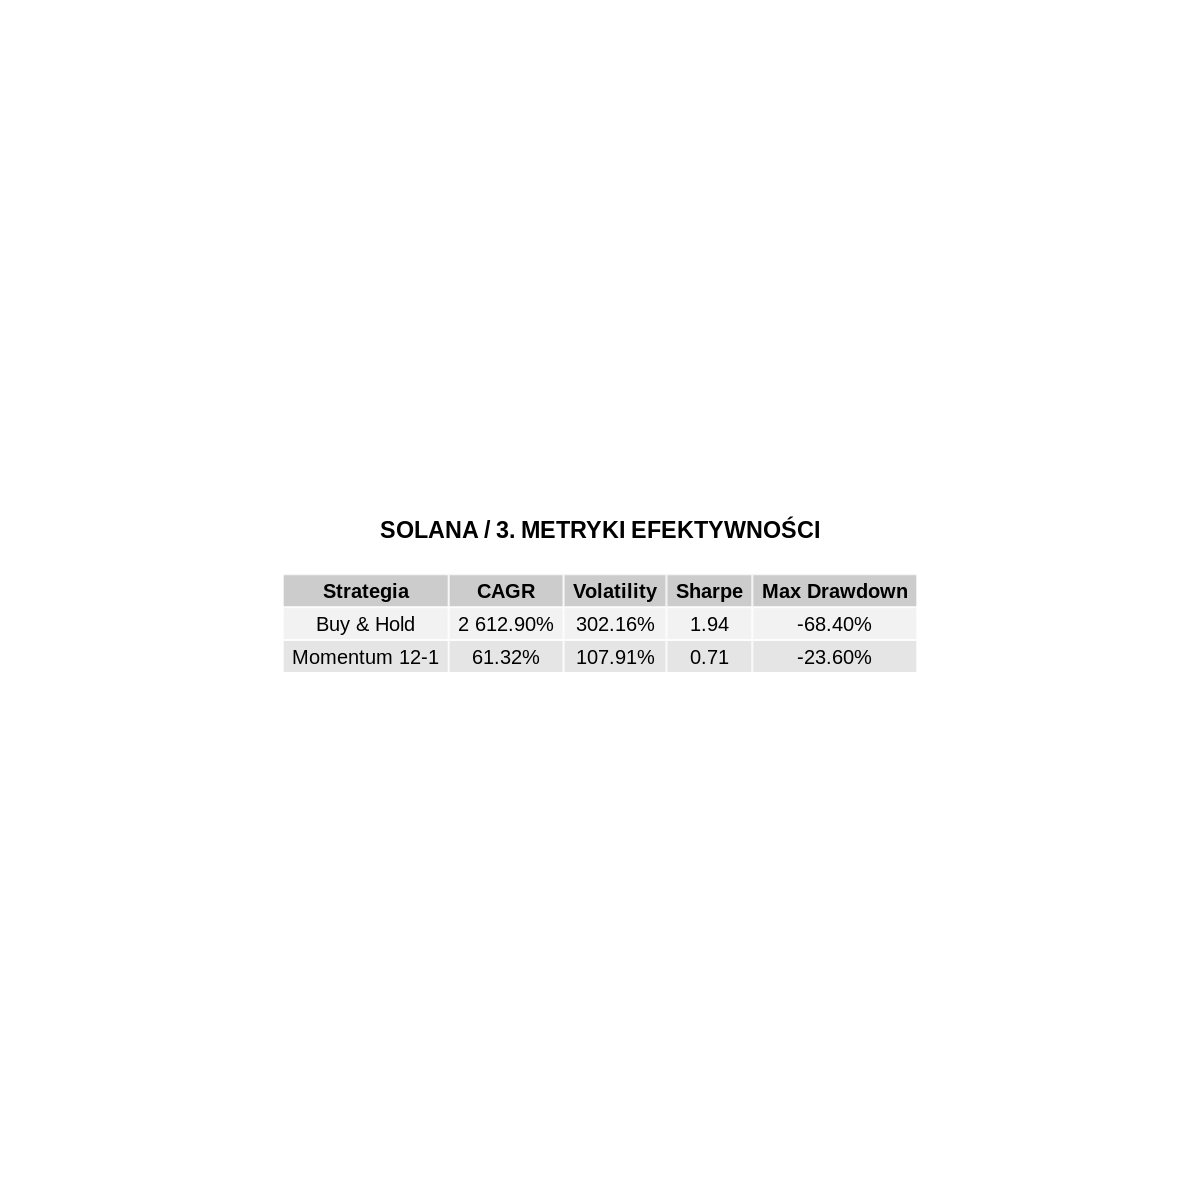


Szczegółowe wartości zwrotów rocznych:
 Year Buy&Hold Momentum12-1
 2020  118.64%        0.00%
 2021  703.66%       76.05%



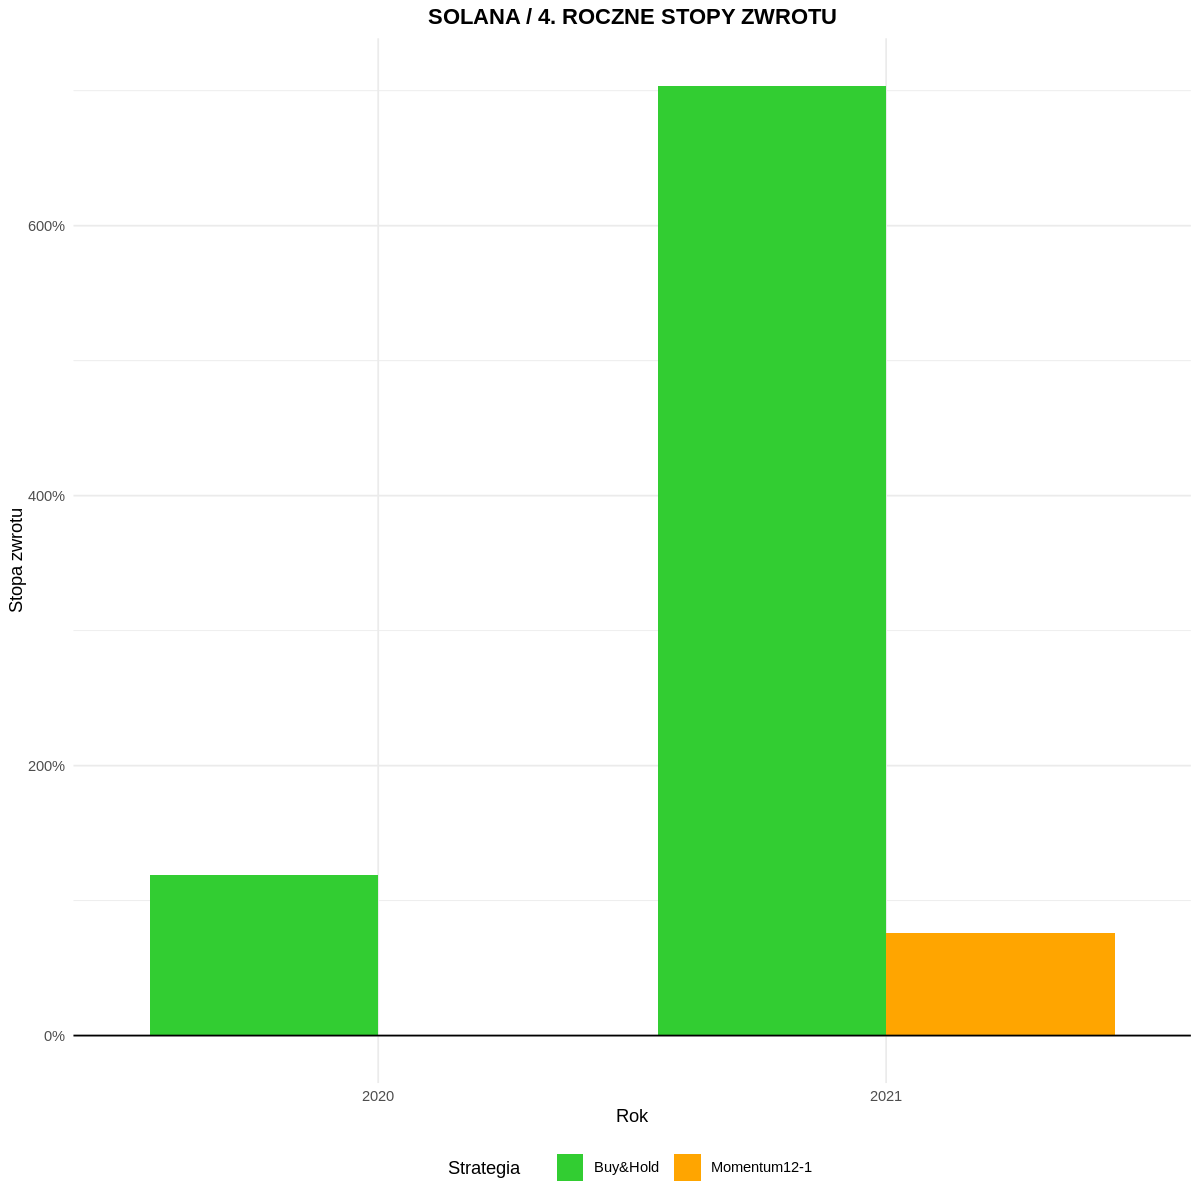

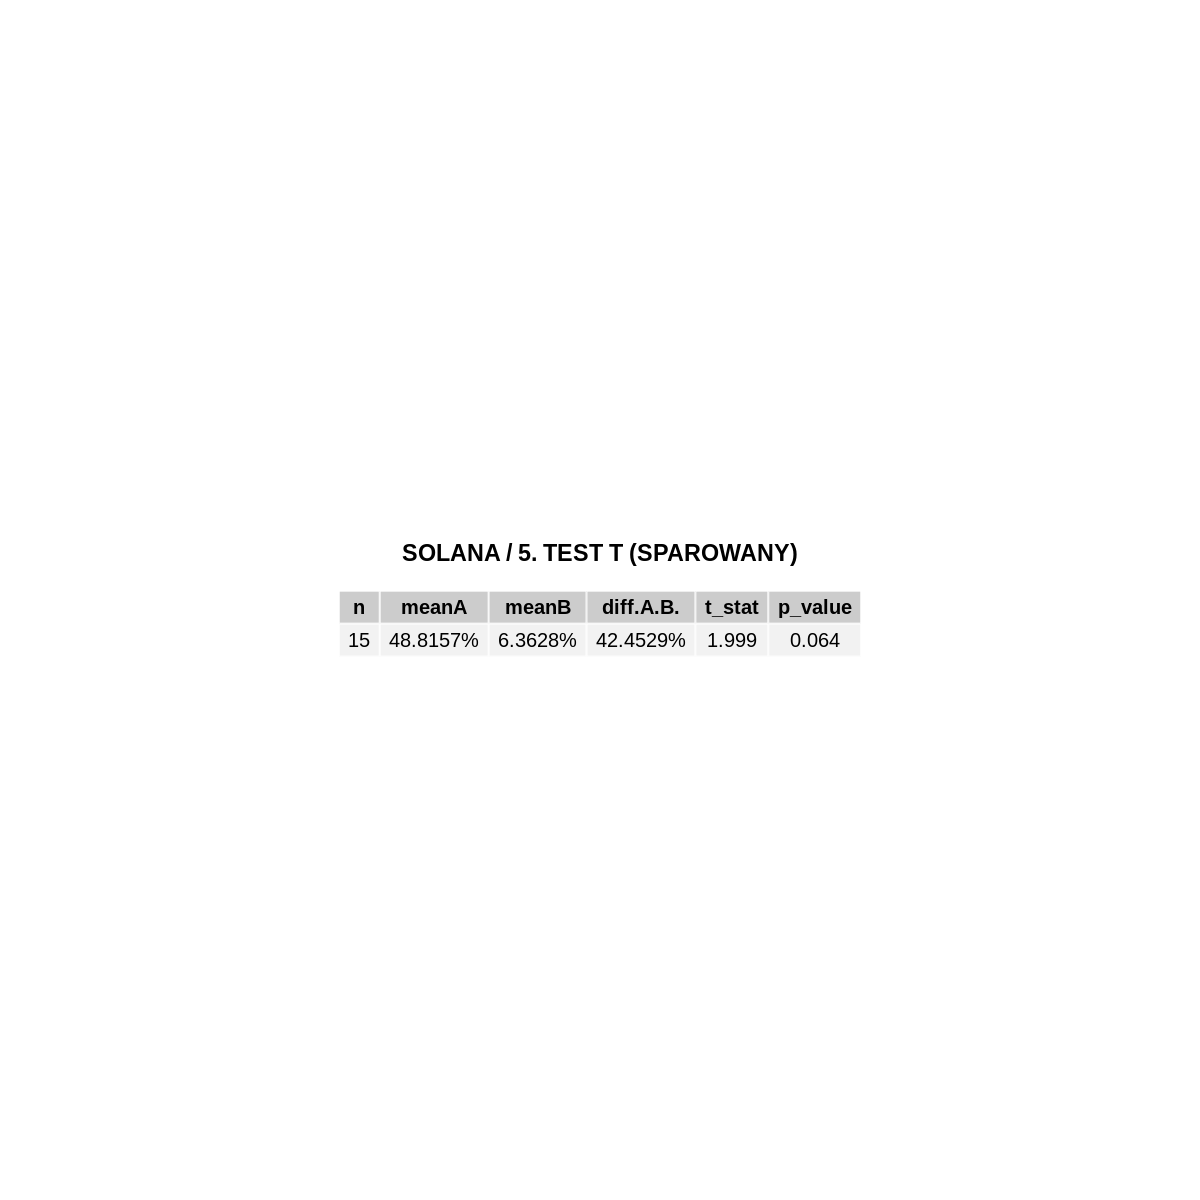

In [34]:
options(repr.plot.height = 10, repr.plot.width = 10)
# SOLANA
results_sol <- run_analysis(SOL_prices_m, "SOLANA")